# TODO:

1. Re-create all plots with new models and multidms version
2. re-compute functional scores such that the counts are collapsed first. Could use dms_variants API
3. papermill all parameters

# Spike Analysis

This notebook contains the entire empirical analysis on the three spike homologs as seen in our manuscript _Jointly modeling deep mutational scans identifies shifted mutational effects among SARS-CoV-2 spike homologs_.

## Computational platform environment

This section shows the attributes of the machine which ran this notebook, as well as imports the necessary dependencies.

Operating system

In [1]:
! grep -E '^(VERSION|NAME)=' /etc/os-release

NAME="Ubuntu"
VERSION="18.04.6 LTS (Bionic Beaver)"


Hardware (Processors and RAM)

In [2]:
! lshw -class memory -class processor

                              *-memory
       description: System memory
       physical id: 0
       size: 996GiB
  *-cpu
       product: AMD EPYC 75F3 32-Core Processor
       vendor: Advanced Micro Devices [AMD]
       physical id: 1
       bus info: cpu@0
       size: 1499MHz
       capacity: 2950MHz
       width: 64 bits
       capabilities: fpu fpu_exception wp vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp x86-64 constant_tsc rep_good nopl xtopology nonstop_tsc cpuid extd_apicid aperfmperf pni pclmulqdq monitor ssse3 fma cx16 pcid sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand lahf_lm cmp_legacy svm extapic cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw ibs skinit wdt tce topoext perfctr_core perfctr_nb bpext perfctr_llc mwaitx cpb cat_l3 cdp_l3 invpcid_single hw_pstate ssbd ibrs ibpb stibp vmmcall fsgsbase bmi1 avx2 smep bmi2 invpcid cqm rdt_a rdseed adx smap clflushopt clwb s

GPU's

In [3]:
%env CUDA_VISIBLE_DEVICES=0
! nvidia-smi -L

env: CUDA_VISIBLE_DEVICES=0
GPU 0: NVIDIA A100 80GB PCIe (UUID: GPU-414cb1bd-372a-4926-b140-b734687c927f)


GPU 1: NVIDIA A100 80GB PCIe (UUID: GPU-e54c2054-5be3-ebd0-e22e-b98441ec664f)


In [4]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
import pickle
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
import matplotlib.patches as patches
import matplotlib.colors as colors
import numpy as np
import scipy
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
import shutil
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.PDBList import PDBList
from Bio.PDB.DSSP import DSSP
from Bio import SeqIO
import multidms
%matplotlib inline

This was notebook was run with the following `multidms` version.

In [5]:
multidms.__version__

'0.3.3'

set papermill parameters which define notebook behavior

In [6]:
output_dir = 'results/spike_analysis'
# define the fitting parameters
scale_coeff_lasso_shift = [0.0, 5.00e-6, 1.00e-05, 2.00e-05, 4.00e-05, 8.00e-05, 1.60e-04, 3.20e-04, 6.40e-04] # the sweep of lasso coefficient params
alpha_d=True
scale_coeff_ridge_alpha_d=1e-3
num_training_steps = 30
iterations_per_step = 1000 # default 20000
# init_beta_naught = 5.0 # We've found that we need to start with a higher beta_naught to get the model to converge correctly,
scale_coeff_ridge_beta = 0.0 # the sweep of ridge coefficient params
train_frac = 0.8 # fraction of data to use for cross validation training.
lasso_choice = 4.00e-05 # the lasso coefficient to use for the final model

Set some global configurations for plotting.

In [7]:
if not os.path.exists(output_dir): os.mkdir(output_dir)

rc_kwargs = {
    'legend.frameon': False,
    "font.size" : 11,
    "font.weight" : "normal"
}

plt.rcParams.update(**rc_kwargs)

## Input Data
Load and organize the funcational score dms data.

We begin with 16 individual sets of barcoded variants and their associated functional scores pre-computed. Each set derives from a single DMS experiment using one of Delta, Omicron BA.1, or Omicron BA.2 as the experimental wildtype. First, we parse the filenames to get experimental attributes tied in with the individual datasets as nested pd.DataFrames

In [8]:
func_score_data = pd.DataFrame()

for homolog in ["Delta", "Omicron_BA1", "Omicron_BA2"]:
    
    # functional scores
    func_sel = (
        pd.read_csv(f"data/{homolog}/functional_selections.csv")
        .assign(
            filename = lambda x: f"data/{homolog}/" + 
            x.library + "_" + 
            x.preselection_sample + 
            "_vs_" + x.postselection_sample + 
            "_func_scores.csv"
        )
        .assign(
            func_sel_scores_df = lambda x: x.filename.apply(
                lambda f: pd.read_csv(f)
            )   
        )
        .assign(
            len_func_sel_scores_df = lambda x: x.func_sel_scores_df.apply(
                lambda x: len(x)
            )
        )
        .assign(homolog = homolog)
    )
    func_score_data = pd.concat([func_score_data, func_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
    axis=1
)
func_score_data[['library', 'replicate', 'filename', 'condition']]

,library,replicate,filename,condition
0,Lib-1,1,data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_contro...,Delta-1
1,Lib-1,2,data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_contro...,Delta-1
2,Lib-3,1,data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_contro...,Delta-3
3,Lib-3,2,data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_contro...,Delta-3
4,Lib-4,1,data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_contro...,Delta-4
5,Lib-4,2,data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_contro...,Delta-4
6,Lib-2,1,data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_contro...,Delta-2
7,Lib-2,2,data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_contro...,Delta-2
8,Lib-1,1,data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VSVG_...,Omicron_BA1-1
9,Lib-1,2,data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VSVG_...,Omicron_BA1-1


In [9]:
avail_cond_str = '\n- '.join(list(func_score_data.condition.unique()))
print(f"Available conditions for fitting are:\n- {avail_cond_str}")

Available conditions for fitting are:
- Delta-1
- Delta-3
- Delta-4
- Delta-2
- Omicron_BA1-1
- Omicron_BA1-2
- Omicron_BA1-3
- Omicron_BA2-1
- Omicron_BA2-2


Concatentate each of the individual experiments, keeping track of the library and homolog of each. Output noteable features, for a random sample of 10 

In [10]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    mut_df_replicates = row.func_sel_scores_df.assign(
        homolog=row.homolog,
        library = row.library,
        replicate = row.replicate,
        condition=row.condition
    )
    func_score_df = pd.concat([func_score_df, mut_df_replicates])

# rename, sort index, and fill na (wildtype values) with empty strings
func_score_df = (func_score_df
    .rename(
        {"aa_substitutions_reference":"aa_substitutions"}, 
        axis=1
    )
    .reset_index(drop=True)
    .fillna("")
    .sort_values(by="condition")
)
func_score_df[["library", "barcode", "aa_substitutions", "func_score", "condition"]].sample(10, random_state=0)

  0%|          | 0/16 [00:00<?, ?it/s]

,library,barcode,aa_substitutions,func_score,condition
721925,Lib-3,CGTAAAGTTCCAACAA,G769R D950F R1107M N1192S,-2.1765,Omicron_BA1-3
239549,Lib-4,AATAATTTTCCTACAC,,-2.0202,Delta-4
816259,Lib-1,GATGATACCAAACTAT,K814T L1024I E1207K,-2.1526,Omicron_BA2-1
612980,Lib-2,AAATATCCTACAAGAA,C738Y A890T H1058Y,-9.0995,Omicron_BA1-2
368871,Lib-1,TAATACCGAATCCCCC,A893V S939D A1078T,-4.1550,Omicron_BA1-1
1115330,Lib-2,GTATACATGTATGATG,S71L D1163E S1242N,0.2762,Omicron_BA2-2
410949,Lib-1,GCATTACTACAAATAA,N960K,0.6777,Omicron_BA1-1
971589,Lib-1,CAATATAGCATAGAGG,R78L,0.1378,Omicron_BA2-1
592643,Lib-2,ACAAGCTTTGCAACAA,Y200H,1.3313,Omicron_BA1-2
381265,Lib-1,CTAGTCTCCGACAAAA,F347S D627G I850L,-6.8325,Omicron_BA1-1


Discard all variants with a pre-selection count of 100.

In [11]:
n_pre_threshold = len(func_score_df)
func_score_df.query("pre_count >= 100", inplace=True)
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than the threshold of counts before selection, and were filtered out")

Of 1135096 variants, 120164 had fewer than the threshold of counts before selection, and were filtered out


We only require a functional score, aa substitutions, and condition column for instatiating the `multidms.Data` object. drop the rest.

In [12]:
required_cols = ['func_score', 'aa_substitutions', 'condition']
func_score_df.drop([c for c in func_score_df if c not in required_cols], axis=1, inplace=True)

Remove all variants with string-suffixed sites (indels) and stop codon wildtypes.

In [13]:
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/1014932 [00:00<?, ?it/s]

We clip all functional scores at a lower bound of -3.5, and an upper bound of 2.5.

In [14]:
n_below_clip = len(func_score_df.query(f"func_score < -3.5"))
n_above_clip = len(func_score_df.query(f"func_score > 2.5"))
print(f"There are {n_below_clip} variants below the clip theshold, and {n_above_clip} above.")
func_score_df = func_score_df.assign(
    func_score = func_score_df.func_score.clip(-3.5, 2.5)
)

There are 143177 variants below the clip theshold, and 345 above.


Choose two representative biological replicates for each of the three homologs.

In [15]:
experiment_conditions = ["Delta", "Omicron_BA1", "Omicron_BA2"]
replicate_1_experiments = ["Delta-2", "Omicron_BA1-2", "Omicron_BA2-1"]
replicate_2_experiments = ["Delta-4", "Omicron_BA1-3", "Omicron_BA2-2"]

Organize the two replicates and annotate replicates "1" and "2". These each represent a distinct training set such that we may train replicate models and compare their results. Output a random sample of 10 variants.

In [16]:
func_score_df = pd.concat(
    [
        (
            func_score_df
            .query("condition in @replicate_1_experiments")
            .replace(dict(zip(replicate_1_experiments, experiment_conditions)))
            .assign(replicate=1)
        ),
        (
            func_score_df
            .query("condition in @replicate_2_experiments")
            .replace(dict(zip(replicate_2_experiments, experiment_conditions)))
            .assign(replicate=2)
        )
    ]
)
func_score_df = func_score_df.assign(
    n_subs = [
        len(aa_subs.split()) 
        for aa_subs in func_score_df.aa_substitutions
    ]
)
func_score_df.sample(10)

,func_score,aa_substitutions,condition,replicate,n_subs
1084142,-1.8970,D950L,Omicron_BA2,2,1
633686,-3.5000,N122- D339H A653N F981V,Omicron_BA1,1,4
729552,-0.0599,P26L S1175Q,Omicron_BA1,2,2
1027437,0.0226,T827A S1252E,Omicron_BA2,1,2
907543,0.2825,K1157R,Omicron_BA2,2,1
263261,0.1846,,Delta,1,0
711544,-1.5318,I1210T S1239G,Omicron_BA1,2,2
669159,-0.4898,I197T D253F L371S R567K A1020T,Omicron_BA1,2,5
1072901,-3.5000,S27R S1123F Q1208E,Omicron_BA2,2,3
1028709,-0.1358,,Omicron_BA2,1,0


In [17]:
func_score_df.to_csv(f"{output_dir}/training_functional_scores.csv", index=False)

## Variant barcode and mutation background stats

In this section we briedly query and visualize charictaristics of the replicate training sets.

Get the expected number substitutions per variant for each condition replicate.

In [18]:
for group, group_df in func_score_df.groupby(["condition", "replicate"]):
    print(f"{group[0]} - rep {group[1]} has {round(group_df.n_subs.mean(), 5)} subs per variant, on average")

Delta - rep 1 has 2.18671 subs per variant, on average
Delta - rep 2 has 2.29472 subs per variant, on average
Omicron_BA1 - rep 1 has 1.802 subs per variant, on average
Omicron_BA1 - rep 2 has 1.75802 subs per variant, on average
Omicron_BA2 - rep 1 has 2.31117 subs per variant, on average
Omicron_BA2 - rep 2 has 2.32827 subs per variant, on average


Get the number of unique mutations seen in each condition replicate.

In [19]:
for group, group_df in func_score_df.groupby(["condition", "replicate"]):
    print(f"{group[0]} - rep {group[1]} has {len(group_df.aa_substitutions.unique())}")  

Delta - rep 1 has 28515
Delta - rep 2 has 29158
Omicron_BA1 - rep 1 has 70597
Omicron_BA1 - rep 2 has 62129
Omicron_BA2 - rep 1 has 60397
Omicron_BA2 - rep 2 has 57719


Visualize the distribution of barcodes per variant, as well as the distribution of unique backgrounds per mutation.

In [20]:
import warnings
warnings.simplefilter("ignore")

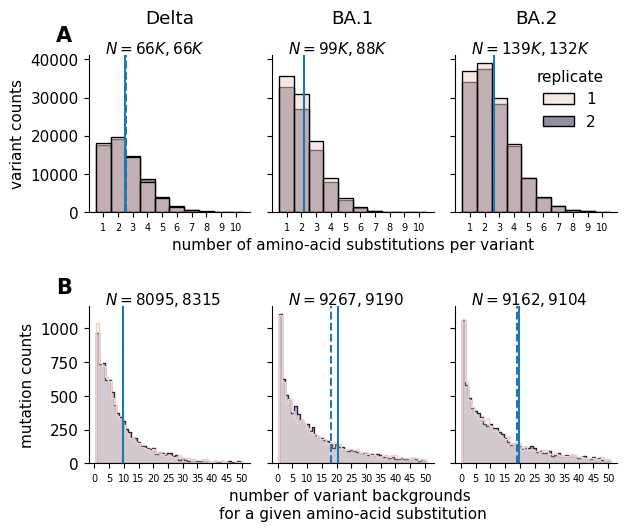

In [21]:
saveas = f"raw_data_summary_barcodes_backgrounds_hist"
logscale=False
fig, ax = plt.subplots(2,3, sharex="row", sharey="row", figsize=[6.4, 5.5])

condition_title = {
    "Delta":"Delta",
    "Omicron_BA1" : "BA.1",
    "Omicron_BA2" : "BA.2"
}

row = 0
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    iter_ax = ax[row, col]
    
    mut_df_replicates = condition_df.query("aa_substitutions != ''")
    mut_df_replicates = mut_df_replicates.assign(
        num_muts = [
            len(aa_subs.split())
            for aa_subs in mut_df_replicates.aa_substitutions
        ]
    )
    
    sns.histplot(mut_df_replicates.query("num_muts <= 10"), x="num_muts", ax=iter_ax, hue="replicate", discrete=True)
    for rep, rep_df in mut_df_replicates.groupby("replicate"):
        mean = rep_df['num_muts'].mean()
        iter_ax.axvline(mean, linestyle=("-" if rep == 1 else "--"))
    
    if logscale: iter_ax.set_yscale('log')
    if col != 2: 
        iter_ax.get_legend().remove()
    n_rep1 = len(mut_df_replicates.query("replicate == 1"))//1000
    n_rep2 = len(mut_df_replicates.query("replicate == 2"))//1000
    iter_ax.text(
        0.1, 1.1, 
        f"$N={n_rep1}K, {n_rep2}K$", 
        ha="left", va="top", 
        transform=iter_ax.transAxes
    )
    xscale = "number of amino-acid substitutions per variant" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    
    ylabel = f"variant counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    iter_ax.set_xticks(
        [i+1 for i in range(10)],
        labels=[i+1 for i in range(10)], 
        ha="center",
        size=7,
        rotation=0
    )
    sns.despine(ax=iter_ax)
    iter_ax.set_title(condition_title[condition], y=1.15)

row = 1
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    iter_ax = ax[row, col]
    mut_df_replicates = pd.DataFrame()
    for rep, rep_df in condition_df.groupby("replicate"):
        
        times_seen = (
            rep_df["aa_substitutions"].str.split().explode().value_counts()
        )
        if (times_seen == times_seen.astype(int)).all():
            times_seen = times_seen.astype(int)
        times_seen = pd.DataFrame(times_seen)
        times_seen.index.name = f"mutation"
        mut_df_replicates = pd.concat([mut_df_replicates, times_seen.assign(replicate=rep).reset_index()])

    sns.histplot(
        mut_df_replicates.query("count <= 50"), 
        x="count", 
        ax=iter_ax, 
        element='step', 
        hue="replicate", 
        discrete=True
    )
    
    for rep, rep_df in mut_df_replicates.groupby("replicate"):
        mean = rep_df['count'].mean()
        iter_ax.axvline(mean, linestyle=("-" if rep == 1 else "--"))
        
    iter_ax.get_legend().remove()
    n_rep1 = len(mut_df_replicates.query("replicate == 1"))
    n_rep2 = len(mut_df_replicates.query("replicate == 2"))
    iter_ax.text(
        0.1, 1.1, 
        f"$N={n_rep1}, {n_rep2}$", 
        ha="left", va="top", 
        transform=iter_ax.transAxes
    )
    
    xscale = "number of variant backgrounds \nfor a given amino-acid substitution" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    
    ylabel = f"mutation counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    
    xticks = [i for i in range(0, 51) if i % 5 == 0]
    iter_ax.set_xticks(
        xticks,
        labels=xticks, 
        ha="center",
        size=7,
        rotation=0
    )
    
    sns.despine(ax=iter_ax)

plt.tight_layout()

ax[0,0].text(
    -0.1, 1.06, 
    f"A", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.06, 
    f"B", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)

fig.subplots_adjust(hspace=.6)
fig.savefig(f"{output_dir}/{saveas}.pdf")
fig.savefig(f"{output_dir}/{saveas}.png")
plt.show()

Plot the correlation of variant functional scores (averaged across barcodes) between replicates in each condition, as well as the full distribution of functional scores.

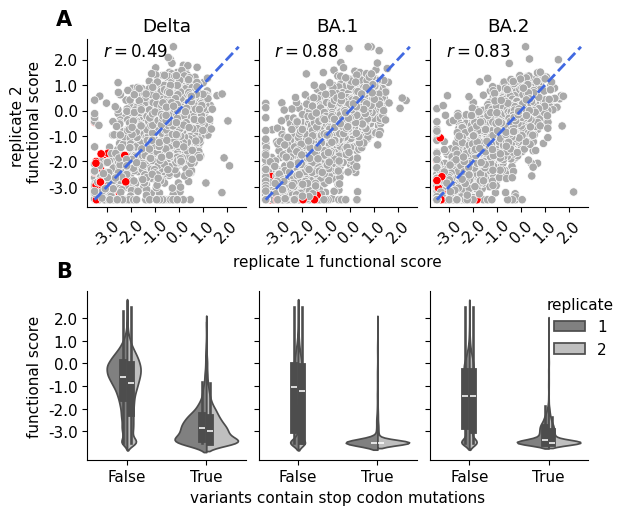

In [22]:
saveas = "replicate_functional_score_correlation_scatter"
pal = sns.color_palette('tab20')

fig, ax = plt.subplots(2,3, sharex="row", sharey="row", figsize=[6.4, 5.3])
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
collapsed_bc_df = collapsed_bc_df.assign(
    is_stop=[True if "*" in aasubs else False for aasubs in collapsed_bc_df.aa_substitutions]
)

is_stop_alpha_dict = {
    True : 0.5,
    False : 0.2
}

lim = [-3.8, 2.8]
ticks = np.linspace(-3, 2, 6)
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    
    row = 0
    iter_ax = ax[row, col]
    
    mut_df_replicates = reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="inner"
        ),
        [
            rep_df.rename({"func_score":f"rep_{rep}_func_score"}, axis=1).set_index("aa_substitutions")
            for rep, rep_df in condition_df.groupby("replicate") 
        ],
    )
    
    mut_df_replicates = mut_df_replicates.assign(
        is_stop=[True if "*" in aasubs else False for aasubs in mut_df_replicates.index.values]
    )
    mut_df_replicates = mut_df_replicates.assign(
        n_subs=[len(aasubs.split()) for aasubs in mut_df_replicates.index.values]
    )
    
    alpha = [is_stop_alpha_dict[istp] for istp in mut_df_replicates.is_stop]
    sns.scatterplot(
        mut_df_replicates, 
        x="rep_1_func_score", 
        y="rep_2_func_score", 
        ax =iter_ax,
        # alpha=alpha,
        hue="is_stop",
        hue_order=[False, True],
        palette=["darkgrey", "red"]
    )
    
    iter_ax.plot([-3.5, 2.5], [-3.5, 2.5], "--", lw=2, c="royalblue")
    
    iter_ax.set_ylim(lim)
    iter_ax.set_xlim(lim)
    if col == 0:
        iter_ax.set_yticks(ticks, labels=ticks)
    iter_ax.set_xticks(ticks, labels=ticks, rotation=45)
    
    corr = pearsonr(mut_df_replicates["rep_1_func_score"], mut_df_replicates["rep_2_func_score"])[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.1, 0.9), 
        xycoords="axes fraction", 
        fontsize=12
    )
    iter_ax.set_title(condition)
    iter_ax.get_legend().remove()
    sns.despine(ax=iter_ax)
    
    row = 1
    iter_ax = ax[row, col]
    sns.violinplot(
        condition_df,
        x="is_stop",
        y="func_score",
        hue="replicate",
        split=True,
        palette=["0.5", "0.75"],
        ax=iter_ax
    )
    
    sns.despine(ax=iter_ax)
    if col != 2:
        iter_ax.get_legend().remove()
    else:
        iter_ax.legend(bbox_to_anchor = (1.25, 1.05), title="replicate")
    if col == 0:
        iter_ax.set_yticks(ticks, labels=ticks)

ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("replicate 2 \n functional score")

ax[0,1].set_xlabel("replicate 1 functional score")
ax[0,1].set_title("BA.1")
ax[0,2].set_xlabel("")
ax[0,2].set_title("BA.2")

ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("functional score")

ax[1,1].set_xlabel("variants contain stop codon mutations")
ax[1,2].set_xlabel("")
ax[1,2].set_ylabel("")
ax[1,1].set_ylabel("")

ax[0,0].text(
    -0.1, 1.06, 
    f"A", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.06, 
    f"B", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)

# fig.suptitle("Variant Functional Score \nReplicate Correlation")
plt.tight_layout()
fig.subplots_adjust(wspace=0.08, hspace = 0.5)
fig.savefig(f"{output_dir}/{saveas}.pdf")
fig.savefig(f"{output_dir}/{saveas}.png")
plt.show()

## Encode data for fitting

Next, we use the `multidms.Data` class to prep our data for fitting. To see the class docstring describing the required input and keyword arguments, toggle the output for the line below.

In [23]:
help(multidms.Data)

Help on class Data in module multidms.data:

class Data(builtins.object)
 |  Data(variants_df: pandas.core.frame.DataFrame, reference: str, alphabet=('A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'), collapse_identical_variants=False, condition_colors=('#0072B2', '#CC79A7', '#009E73', '#17BECF', '#BCDB22'), letter_suffixed_sites=False, assert_site_integrity=False, verbose=False, nb_workers=None, name=None)
 |  
 |  Prep and store one-hot encoding of
 |  variant substitutions data.
 |  Individual objects of this type can be shared
 |  by multiple :py:class:`multidms.Model` Objects
 |  for efficiently fitting various models to the same data.
 |  
 |  Note
 |  ----
 |  You can initialize a :class:`Data` object with a :class:`pandas.DataFrame`
 |  with a row for each variant sampled and annotations
 |  provided in the required columns:
 |  
 |  1. `condition` - Experimental condition from
 |      which a sample measurement was obtained.
 |

Instantiate an object for each of our two replicate training sets, and append them to a list 

In [24]:
datasets = []
for res, fsdf in func_score_df.groupby("replicate"):       

    start = time.time()

    # instantiate data object
    data = multidms.Data(
        fsdf,
        collapse_identical_variants="mean",       # take the average variant func score across barcode replicates
        alphabet=multidms.AAS_WITHSTOP_WITHGAP,   # 
        reference="Omicron_BA1",
        assert_site_integrity=False,
        verbose=True,
        nb_workers=8,
        name=f"rep-{res}" 
    )

    end = time.time()
    prep_time = round(end-start)
    print(f"Finished, time: {prep_time}")

    datasets.append(data)

inferring site map for Delta


  0%|          | 0/28515 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/70597 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/60397 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [144, 143, 69, 145, 70, 211, 25, 26, 24, 157, 158, 898],
dropping: 10983 variantswhich have mutations at those sites.


invalid non-identical-sites: [371], dropping 2041 variants
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 36
inferring site map for Delta


  0%|          | 0/29158 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/62129 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/57719 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [145, 70, 144, 143, 69, 211, 422, 26, 24, 25, 157, 158],
dropping: 10129 variantswhich have mutations at those sites.


invalid non-identical-sites: [371], dropping 1873 variants
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


Finished, time: 34


Change the datasets colors - the only mutible thing about `Data` Objects.

In [25]:
# condition colors must be hex-encoded,
palette = [
    '#F97306',
    '#BFBFBF',
    '#9400D3'
]

conditions = [
    "Delta",
    "Omicron_BA1",
    "Omicron_BA2"
]

cc = {con:col for con, col in zip(conditions, palette)}
for data in datasets:
    data.condition_colors = cc

## Fit Models (Shrinkage Analysis)

For each replicate training set, initialize and fit a set models with variable lasso strength coefficients. Here, we use the `multidms.utils.fit_wrapper` function to handle the instatiation, and parameter fitting. Expand the cell output below to view the function docstring.

In [26]:
fit_params = {
    'scale_coeff_lasso_shift': scale_coeff_lasso_shift,
    'alpha_d': [alpha_d],
    'scale_coeff_ridge_alpha_d':[scale_coeff_ridge_alpha_d],
    'scale_coeff_ridge_beta': [scale_coeff_ridge_beta],
    'num_training_steps': [num_training_steps],
    'iterations_per_step':[iterations_per_step],
}

fit_params["dataset"] = datasets
_, _, models = multidms.fit_models(fit_params, n_threads=-1)
pickle.dump(models, open(f"{output_dir}/full_models.pkl", "wb"))

The cell above saves the models and their relevant hyper-parameters in a `DataFrame` to a `pickle` binary file. Hense, If it's already been run, and you want to execute the code below _without_ re-fitting, the following cell will load that binary file.

In [28]:
models["replicate"] = models.dataset_name.str.split("-").str[-1].astype(int)

In [29]:
# set some global variables
# columns name
model_name = "model"

# the number of times a mutation must be seen in each condition to be included in downstream analysis
times_seen_threshold = 1

# The chosen lasso strength for our final spike model results
chosen_lasso_strength = 4e-5

Plot the model loss over training steps, as provided by `fit_wrapper`.

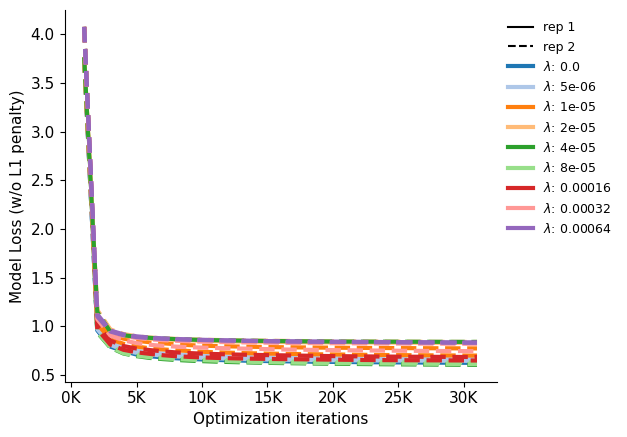

In [30]:
saveas="convergence_all_lasso_lines"
cmap=plt.get_cmap("tab20")


fig, ax = plt.subplots(1,figsize=[6.4,4.5])
color_idx = -1
for i, (model, model_row) in enumerate(models.iterrows()):
    if i%2 == 0: color_idx += 1

    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[color_idx],
        lw=3,
        linestyle="-" if model_row.replicate == 0 else "--",
        label=f"rep: {model_row.replicate} scale_coeff: {model_row.scale_coeff_lasso_shift}"
    )

ticks = range(0, 30001, 5000)
labels = [f"{t//1000}K" for t in ticks]
ax.set_xticks(ticks, labels, rotation=0, ha='center')
ax.set_ylabel("Model Loss (w/o L1 penalty)")
ax.set_xlabel("Optimization iterations")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=5,
        linewidth=3,
        label="$\lambda$: "+str(lasso)
    )
    for lasso, color in zip(models.scale_coeff_lasso_shift.unique(), cmap.colors)
]

elements = [black_line, black_dashed] + lasso_color_handles
ax.legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)
sns.despine(ax=ax)
ax.set_ylim()
plt.tight_layout()
fig.savefig(f"{output_dir}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{output_dir}/{saveas}.png",bbox_inches='tight')
plt.show()

## Model Evaluation and Selection

In [31]:
model_collection = multidms.ModelCollection(models)

In [32]:
chart, sparsity_df = model_collection.shift_sparsity(return_data=True, height_scalar=100) # TODO raise issue to fix height scalar
print(sparsity_df.head())
chart

cache miss - this could take a moment
  dataset_name  scale_coeff_lasso_shift       mut_type    mut_param  sparsity
0        rep-1                 0.000000  nonsynonymous  shift_Delta  0.234082
1        rep-1                 0.000000           stop  shift_Delta  0.247678
2        rep-1                 0.000005  nonsynonymous  shift_Delta  0.312857
3        rep-1                 0.000005           stop  shift_Delta  0.396285
4        rep-1                 0.000010  nonsynonymous  shift_Delta  0.381122


alt.FacetChart(...)

In [33]:
chart, corr_df = model_collection.mut_param_dataset_correlation(width_scalar=200, return_data=True)
print(corr_df.head())
chart

      datasets mut_param  correlation  scale_coeff_lasso_shift
0  rep-1,rep-2      beta     0.837209                 0.000000
0  rep-1,rep-2      beta     0.839758                 0.000005
0  rep-1,rep-2      beta     0.838824                 0.000010
0  rep-1,rep-2      beta     0.838579                 0.000020
0  rep-1,rep-2      beta     0.837910                 0.000040


alt.FacetChart(...)

## Cross Validation

In [34]:
train_frac=0.8
seed=4
train, test = [], {}
for replicate, fs_df in func_score_df.groupby("replicate"):

    dataset = fs_df.sample(frac=1, random_state=seed)
    train_split, test_split = dataset.iloc[:int(len(dataset) * train_frac)], dataset.iloc[int(len(dataset) * train_frac):]
    name = f"rep-{replicate}"
    
    train.append(
        multidms.Data(
            train_split,
            collapse_identical_variants="mean",
            reference="Omicron_BA1", 
            alphabet = multidms.AAS_WITHSTOP_WITHGAP, 
            verbose=True,
            name = name
        )
    )

    test[name] = test_split


inferring site map for Delta


  0%|          | 0/27342 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/57528 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/56907 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [144, 143, 69, 145, 70, 211, 25, 26, 24, 157, 158, 898],
dropping: 9793 variantswhich have mutations at those sites.


invalid non-identical-sites: [371], dropping 1732 variants
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


inferring site map for Delta


  0%|          | 0/27945 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/50638 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/54489 [00:00<?, ?it/s]

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [145, 70, 144, 143, 69, 211, 422, 26, 24, 25, 157, 158],
dropping: 9059 variantswhich have mutations at those sites.


invalid non-identical-sites: [371], dropping 1643 variants
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


In [35]:
fit_params["dataset"] = train 
_, _, models_cv = multidms.model_collection.fit_models(fit_params, n_threads = -1)

In [36]:
mc = multidms.model_collection.ModelCollection(models_cv)
mc.add_validation_loss(test, overwrite=True)

In [37]:
cross_validation_df = mc.get_conditional_loss_df()
cross_validation_df.head()

,dataset_name,scale_coeff_lasso_shift,condition,loss,split
0,rep-1,0.0,Delta,0.217511,training
1,rep-1,0.000005,Delta,0.222574,training
2,rep-1,0.00001,Delta,0.227321,training
3,rep-1,0.00002,Delta,0.235090,training
4,rep-1,0.00004,Delta,0.249183,training


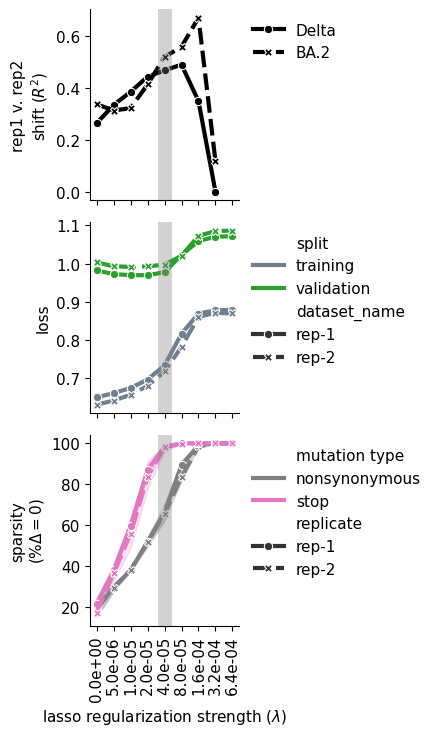

In [38]:
saveas="shrinkage_analysis_trace_plots_beta"

fig, ax = plt.subplots(3, figsize=[4.5, 7.5], sharex=True)

# replicate correlation
iter_ax = ax[0]
sns.lineplot(
    data=(
        corr_df
        .query("mut_param.str.contains('shift')")
        .rename({"mut_param":"shift params"}, axis=1)
        # .replace({"Data-1":"rep-1", "Data-2":"rep-2"})
        .replace({"shift_Delta":"Delta", "shift_Omicron_BA2":"BA.2"})
        .assign(
            scale_coeff_lasso_shift = [
                f"{l:.1e}" 
                for l in corr_df.query("mut_param.str.contains('shift')").scale_coeff_lasso_shift
            ],
            correlation = lambda x: x.correlation**2
        )
        .reset_index(drop=True)
    ),
    x="scale_coeff_lasso_shift",
    y="correlation",
    style="shift params",
    markers=True,
    ax=iter_ax,
    linewidth=3,
    color="black"
)
iter_ax.set_ylabel("rep1 v. rep2\nshift $(R^2)$")
# move legend outside of plot
iter_ax.legend(
    bbox_to_anchor = (1, 1), 
    loc='upper left', 
    frameon=False
)



# plot loss
iter_ax = ax[1]
sns.lineplot(
    data = (
        cross_validation_df.query("condition=='total'")
        .assign(
            # lasso_strength = [f"{l:.1e}" for l in sparsity_df.scale_coeff_lasso_shift]
            # lasso_strength = lambda x: f"{x.scale_coeff_lasso_shift:.1e}"
            lasso_strength = lambda x: x['scale_coeff_lasso_shift'].apply(lambda y: f'{y:.1e}')
        )
    ),
    x="lasso_strength",
    y="loss",
    ax=iter_ax,
    hue="split",
    style="dataset_name",
    palette={"training":"slategrey", "validation":"#2CA02C"},
    markers=True,
    linewidth=3
)
# move legend outside of plot
iter_ax.legend(
    bbox_to_anchor = (1, 1), 
    loc='upper left', 
    frameon=False
)


# plot sparsity
iter_ax = ax[2]
sns.lineplot(
    data=(
        sparsity_df
        .rename({"dataset_name":"replicate"}, axis=1)
        .rename({"mut_param":"shift params", "mut_type":"mutation type"}, axis=1)
        # .replace({"Data-0":"rep-1", "Data-1":"rep-2"})
        .replace({"nonsynonymous":"nonsynonymous", "stop":"stop"})
        .replace({"shift_Delta":"Delta", "shift_Omicron_BA2":"BA.2"})
        .assign(
            scale_coeff_lasso_shift = [f"{l:.1e}" for l in sparsity_df.scale_coeff_lasso_shift],
            sparsity_percent = lambda x: x.sparsity * 100,
        )
    ),
    x="scale_coeff_lasso_shift",
    y="sparsity_percent",
    hue="mutation type",
    style="replicate",
    palette={"nonsynonymous":"grey", "stop":"#E377C2"},
    markers=True,
    legend=True,
    ax=iter_ax,
    linewidth=3
)
# move legend outside of plot
iter_ax.legend(
    bbox_to_anchor = (1, 1), 
    loc='upper left', 
    frameon=False
)
# rotate x labels
iter_ax.set_xticklabels(
    iter_ax.get_xticklabels(), 
    rotation=90, 
    ha='center'
)
iter_ax.set_ylabel("sparsity\n$(\%\Delta=0)$")
iter_ax.set_xlabel(f"lasso regularization strength ($\lambda$)")

for axes in ax:
    axes.axvline(
        f"{chosen_lasso_strength:.1e}", 
        color="grey",
        linewidth=10,
        alpha=0.35
    )

sns.despine(fig)
plt.tight_layout()
# plt.tight_layout()
fig.savefig(f"{output_dir}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{output_dir}/{saveas}.png",bbox_inches='tight')
# plt.show()

plt.show()

## Global epistasis fits

Here, we take a look at the fit of the sigmoidal global epistasis function (at the chosen lasso coefficient of 5e-5) to the data.

For each replicate at the chosen lasso strength, we get the training data predictions using `model.get_variants_df`, and use `model.get_condition_params` paried with `model.model_components` for visualizing the global epistasis function with the current model parameters. See the function docs strings for the relevant details of each.

In [39]:
chosen_replicate_models = models.query("scale_coeff_lasso_shift == @chosen_lasso_strength")
replicate_data = {}
for row_idx, replicate_row in chosen_replicate_models.iterrows():
    model = replicate_row[model_name]

    # get training data variants and their respective 
    mut_df_replicates = model.get_variants_df(phenotype_as_effect=False)

    # find the low/high bound of the training data and use those to make
    # global epistasis predictions across the range for plotting
    xlb, xub = [-1, 1] + np.quantile(mut_df_replicates.predicted_latent, [0.05, 1.0])
    additive_model_grid = np.linspace(xlb, xub, num=1000)

    # make predictions on hypothetical data points between lower, and upper bound
    current_params = model.get_condition_params(model.data.reference)
    latent_preds = model.model_components["g"](current_params["theta"], additive_model_grid)
    shape = (additive_model_grid, latent_preds)   

    # save and organize the data for plotting
    replicate_data[replicate_row.replicate] = {
        "variants_df" : mut_df_replicates,
        "wildtype_df" : model.wildtype_df,
        "epistasis_shape" : shape,
        "condition_colors" : model.data.condition_colors
    }

In [40]:
replicate_data.keys()

dict_keys([1, 2])

Plot the observed functional scores of a random sample of all variants (20%), as function of both latent phenotype prediction (top), and functional score phenotype prediction (bottom).

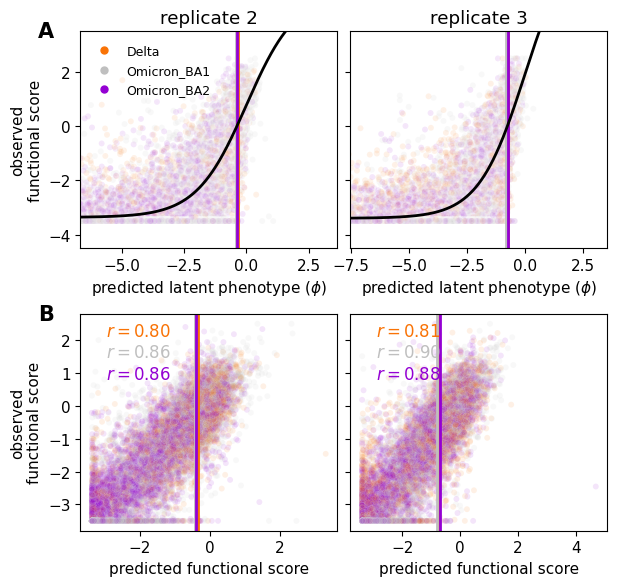

In [41]:
saveas="global_epistasis_and_prediction_correlations"
fig, ax = plt.subplots(2,2, figsize=[6.4,6], sharey='row')    

row=0
for replicate, data in replicate_data.items():

    iter_ax = ax[row, replicate-1]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.2),
        x="predicted_latent",
        y=f"func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1,
        lw=3
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    iter_ax.plot(*data["epistasis_shape"], color="k", lw=2)
    
    xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(data["variants_df"].func_score, [0.05, 1.0])
    iter_ax.set_xlim([xlb, xub])
    iter_ax.set_ylim([ylb, yub])
    iter_ax.set_title(f"replicate {replicate+1}")
    iter_ax.set_ylabel("observed\nfunctional score")
    iter_ax.set_xlabel("predicted latent phenotype ($\phi$)")

row=1
for replicate, data in replicate_data.items():

    iter_ax = ax[row, replicate-1]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.1),
        x="predicted_func_score",
        y=f"func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    iter_ax.set_ylabel("observed\nfunctional score")
    iter_ax.set_xlabel("predicted functional score")

    start_y = 0.9
    for c, cdf in data["variants_df"].groupby("condition"):
        r = pearsonr(
            cdf["predicted_func_score"],
            cdf["func_score"]
        )[0]
        iter_ax.annotate(
            f"$r = {r:.2f}$",
            (0.1, start_y),
            xycoords="axes fraction",
            fontsize=12,
            c=model.data.condition_colors[c],
        )
        start_y += -0.1


elements = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None',markersize=5, label=condition)
    for condition, color in replicate_data[1]["condition_colors"].items()
]


ax[0, 0].legend(
    handles=elements, 
    bbox_to_anchor = (0., .99), 
    loc='upper left', 
    frameon=False, 
    fontsize=9
)
    
    
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)

ax[0,0].text(
    -0.1, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)


fig.savefig(f"{output_dir}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{output_dir}/{saveas}.png",bbox_inches='tight')
plt.show()

## Shifted mutations (interactive altair chart)

The easiest way to view shifted mutations is to create an interactive `altair` chart using `multidms.plot.mut_shift_plot`. This function can take a single model, or a collection of models in a dictionary if you want to visualize the aggregated (mean) results of shared mutations between models. Toggle the drop down for the cell below to see details on using this function. 

In [42]:
help(multidms.ModelCollection.mut_param_heatmap)

Help on function mut_param_heatmap in module multidms.model_collection:

mut_param_heatmap(self, query=None, mut_param='shift', aggregate_func='mean', inner_merge_dataset_muts=True, times_seen_threshold=0, phenotype_as_effect=True, **kwargs)
    Create lineplot and heatmap altair chart
    across replicate datasets.
    This function optionally applies a given `pandas.query`
    on the fit_models dataframe that should result in a subset of
    fit's which make sense to aggregate mutational data across, e.g.
    replicate datasets.
    It then computes the mean or median mutational parameter value
    ("beta", "shift", or "predicted_func_score")
    between the remaining fits. and creates an interactive altair chart.
    
    
    Note that this will throw an error if the queried fits have more
    than one unique hyper-parameter besides "dataset_name".
    
    
    Parameters
    ----------
    query : str
        The query to apply to the fit_models dataframe. This should be
        

Here, we create the interactive chart by feeding the function a dictionary containing the two replicate models, and specifying:

1. times_seen_threshold = 1, meaning for a mutation to be included, it must be seen at least once in every condition
2. inlcude_beta = False, we only wish to see the shifted parameters visualized, not the respective _effect_ (beta) parameters. (note that respective effect values will be added as a tooltip when hovering over any shift mutation).

To view the chart, toggle the output of the cell below.

In [43]:
mc = multidms.ModelCollection(models.drop(columns="replicate"))

In [44]:
chart = mc.mut_param_heatmap(query=f"scale_coeff_lasso_shift == {chosen_lasso_strength}", times_seen_threshold=times_seen_threshold)
chart.save(f"{output_dir}/interactive_shift_chart.html")
chart

cache miss - this could take a moment


alt.VConcatChart(...)

## Shifted mutations (manually queried)

In [47]:
def combine_replicate_muts(fit_dict, predicted_func_scores = False, how="inner", **kwargs):
    """
    Take a dictionary of fit objects, with key's as the prefix for individual
    replicate values, and merge then such that all individual and average mutation
    values are present in both.
    """
    # obtain and curate each of the replicate mutational dataframes
    mutations_dfs = []
    for replicate, fit in fit_dict.items():
        fit_mut_df = fit.get_mutations_df(**kwargs)
        # drop all "predicted_func_score" and "times seen" columns
        fit_mut_df = fit_mut_df.drop(
            [c for c in fit_mut_df.columns if "times_seen" in c], 
            axis=1
        )

        new_column_name_map = {c: f"{replicate}_{c}" for c in fit_mut_df.columns}
        fit_mut_df = fit_mut_df.rename(new_column_name_map, axis=1)

        mutations_dfs.append(fit_mut_df)

    # merge each of the replicate mutational dataframes
    mut_df = reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how=how
        ),
        mutations_dfs,
    )

    column_order = []
    # now compute replicate averages
    for c in fit.mutations_df.columns:

        if not predicted_func_scores and "predicted_func_score" in c:
            continue

        if c == "mutation" or "times_seen" in c: # or "predicted_func_score" in c:
            continue
        
        cols_to_combine = [f"{replicate}_{c}" for replicate in fit_dict.keys()]

        # just keep one replicate wt, site, mut .. as they are shared.
        if c in ["wts", "sites", "muts"]:
            mut_df[c] = mut_df[cols_to_combine[0]]
            mut_df.drop(cols_to_combine, axis=1, inplace=True)

        # take the average.
        else:
            mut_df[f"avg_{c}"] = mut_df[cols_to_combine].mean(axis=1)
            column_order += cols_to_combine + [f"avg_{c}"]

    return mut_df.loc[:, ["wts", "sites", "muts"] + column_order]

In [49]:
mut_df_replicates = combine_replicate_muts(
    {
        f"{fit.dataset_name}".split("-")[-1]: fit.model
        for fit in models.query(f"scale_coeff_lasso_shift == {chosen_lasso_strength}").itertuples()
    },
    predicted_func_scores=True,
    how="inner",
    times_seen_threshold=times_seen_threshold
)
mut_df_replicates

,wts,sites,muts,1_beta,2_beta,avg_beta,1_shift_Delta,2_shift_Delta,avg_shift_Delta,1_shift_Omicron_BA2,...,avg_shift_Omicron_BA2,1_predicted_func_score_Delta,2_predicted_func_score_Delta,avg_predicted_func_score_Delta,1_predicted_func_score_Omicron_BA1,2_predicted_func_score_Omicron_BA1,avg_predicted_func_score_Omicron_BA1,1_predicted_func_score_Omicron_BA2,2_predicted_func_score_Omicron_BA2,avg_predicted_func_score_Omicron_BA2
mutation,,,,,,,,,,,,,,,,,,,,,
M1I,M,1,I,-2.924932,-4.256726,-3.590829,0.000000,0.000000,0.000000,-0.000000,...,0.000000,-3.162696,-3.348626,-3.255661,-3.009065,-3.236155,-3.122610,-3.085516,-3.409368,-3.247442
F2L,F,2,L,0.200928,0.207115,0.204021,-0.000000,-0.000000,0.000000,-0.204654,...,-0.102327,0.287689,0.366644,0.327167,0.405955,0.487242,0.446598,-0.200109,0.107339,-0.046385
F2S,F,2,S,0.194773,-0.074343,0.060215,-0.000000,0.000000,0.000000,0.000000,...,0.000000,0.275053,-0.286178,-0.005562,0.393345,-0.166355,0.113495,0.195843,-0.525584,-0.164871
F2V,F,2,V,0.239144,-0.030672,0.104236,-0.086489,-0.153066,-0.119778,0.000000,...,0.000000,0.188819,-0.521577,-0.166379,0.484417,-0.069216,0.207601,0.286191,-0.431950,-0.072880
V3A,V,3,A,-0.007044,-0.047157,-0.027101,-0.000000,-0.000000,0.000000,-0.000000,...,-0.001301,-0.133532,-0.225989,-0.179760,-0.013975,-0.106083,-0.060029,-0.206590,-0.473092,-0.339841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S1252T,S,1252,T,-0.132241,-0.189524,-0.160882,-0.000000,0.000000,0.000000,-0.074971,...,-0.037485,-0.379343,-0.533716,-0.456529,-0.258642,-0.414259,-0.336450,-0.586871,-0.763869,-0.675370
S1252V,S,1252,V,0.161672,0.177089,0.169381,0.262923,-0.185348,0.038788,-0.044192,...,-0.080998,0.750125,-0.138738,0.305693,0.325693,0.414606,0.370149,0.039893,-0.233608,-0.096858
S1252W,S,1252,W,0.046494,0.283281,0.164887,0.000000,0.000000,0.000000,0.018787,...,-0.015843,-0.026414,0.553441,0.263513,0.092733,0.674209,0.383471,-0.064218,0.168365,0.052073


We need the sitemap of inferred wildtype amino acids at each site, for each condition. This is easily accessible via the `Model.data` attribute 

In [51]:
site_map = model.data.site_map
site_map.loc[10:20, :]

,Delta,Omicron_BA1,Omicron_BA2
10,L,L,L
11,V,V,V
12,S,S,S
13,S,S,S
14,Q,Q,Q
15,C,C,C
16,V,V,V
17,N,N,N
18,L,L,L
19,R,T,I


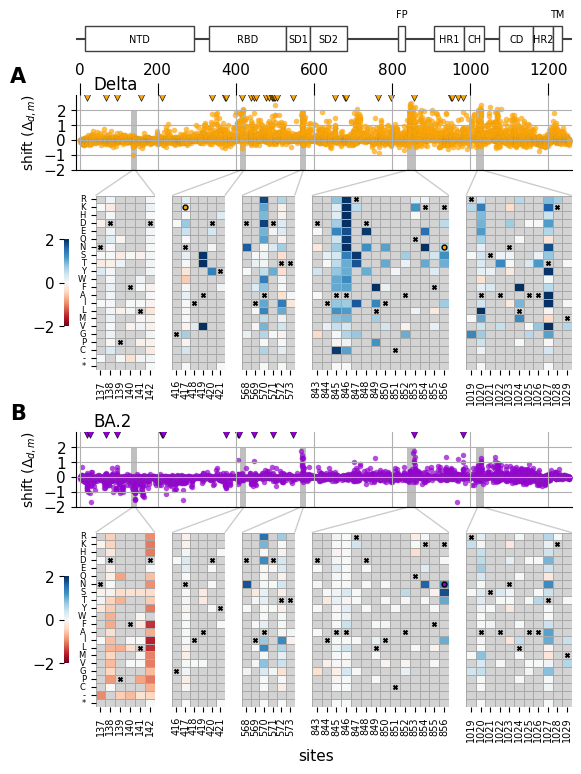

In [52]:
# some renaming and wrangling
mut_df_replicates["sense"] = ["stop" if mut == "*" else "nonsynonymous" for mut in mut_df_replicates.muts]
rename_omicron = {
    c:"_".join(c.split("_")[:2]+[c.split("_")[3]])
    for c in mut_df_replicates.columns if "Omicron" in c
}
mut_df_replicates.rename(rename_omicron, axis=1, inplace=True)
site_map = site_map.reset_index().rename(
    {"index":"sites", "Omicron_BA2": "BA2", "Omicron_BA1":"BA1"}, axis=1
).set_index("sites")

saveas = "shift_by_site_heatmap_zoom"

site_ranges = {
    "zoom1" : [137, 142],
    "zoom2" : [416, 421],
    "zoom3" : [568, 573],
    "zoom4" : [843, 856],
    "zoom5" : [1019, 1029]
}

# heatmap ax width ratios
width_ratios = [(end-start) for key, (start, end) in site_ranges.items()]

# make the first one a little bigger for the color bar
width_ratios[0] += width_ratios[0] * 0.5


# Plot domain architecture in primary sequence
# based on structure papers (Gobeil et al., 2022, Molecular Cell)
# (Duan et al., 2020, Frotiers in Immunology)
domain_dict = {
    'NTD' : [13, 293],
    'RBD' : [330, 528],
    'SD1' : [528, 590],
    'SD2' : [590, 685],
    'FP' : [815, 834],
    'HR1' : [907, 985],
    'CH' : [985, 1035],
    'CD' : [1075, 1162],
    'HR2' : [1162, 1211],
    'TM' : [1211, 1234],
}

sort_order = [
    "R","K","H","D","E","Q","N","S",
    "T","Y","W","F","A","I","L","M",
    "V","G","P","C","-","*",
]

fig = plt.figure( figsize=[6.4, 9])
axs = fig.subplot_mosaic(
    [
        ["Annotation"]*5,
        ["Delta"]*5,
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        ["."]*5,
        ["BA2"]*5,
        [f"{k}_BA2" for k in list(site_ranges.keys())],
        [f"{k}_BA2" for k in list(site_ranges.keys())]
    ],
    
    height_ratios=[
        1.5, 
        2, 
        2, 
        2,
        0.3,
        2,
        2, 
        2
    ],
    empty_sentinel=".",
    # set the width ratios between the columns
    width_ratios=width_ratios,
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)

# derived from
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axes_zoom_effect.html
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect03(ax1, ax2, xmin, xmax, **kwargs):

    mybbox1 = ax1.bbox
    
    bbox = Bbox.from_extents(xmin, 0, xmax, 1)
    mybbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=2, loc2a=3, loc1b=1, loc2b=4,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

#############
# sitewise
#############


pal = sns.color_palette('colorblind')
cs = ['darkviolet', 'orange']
cs = {
    'BA2' : 'darkviolet', 
    'Delta' : 'orange'
}

# Plot per-site metric
metric_prefix = 'max_abs_shift_'
for (i, homolog) in enumerate(['BA2', 'Delta']):

    sns.scatterplot(
        x='sites', 
        y=f'avg_shift_{homolog}',
        data=mut_df_replicates, 
        s=15,
        alpha=0.7,
        edgecolor="grey",
        linewidth=0.05,
        ax=axs[homolog], 
        color=cs[homolog],
        label=""
    )
    
    nis = site_map.query(f"{homolog} != BA1")
    sns.scatterplot(
        x='sites', 
        y=np.repeat(2.9, len(nis)),
        data=nis, 
        s=30,
        ax=axs[homolog],
        marker='v',
        facecolor=cs[homolog], 
        edgecolor="k"
    )

    axs[homolog].grid()
    axs[homolog].set(
        xlim=[-10,1260],
        ylim=[-2, 3],
        yticks=[-2, -1, 0, 1, 2],
    )
    sns.despine(ax=axs[homolog])
    
    axs[homolog].tick_params(
        axis='x', 
        bottom=False,
        labelbottom=False,
        labeltop=True if homolog == "Delta" else False,
        top=True if homolog == "Delta" else False,
        size=9
    )
    axs[homolog].set_xlabel(None)
    axs[homolog].set_ylabel('shift ($\Delta_{d,m}$)', size=10)


axs["BA2"]._shared_axes['x'].join(axs["BA2"], axs["Delta"])

plot_rectangles = True
for zoom, site_range in site_ranges.items():
    if not plot_rectangles:
        continue
    (site_i, site_j) = site_range
    for (i, homolog) in enumerate(['BA2', 'Delta']):
        rect = patches.Rectangle(
            (site_i-5, -2), site_j-site_i+11, 4,
            edgecolor='none', facecolor='0.75', zorder=0
        )
        axs[homolog].add_patch(rect)
        
        
#############
# Annotation
#############

for (domain, (start, end)) in domain_dict.items():
    rectangle = patches.Rectangle((start, 1), end-start, 2, edgecolor='0.25', facecolor='white')
    axs["Annotation"].add_patch(rectangle)
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry - 0.05 + rectangle.get_height()/2.0
    if domain in ['FP', 'TM']:
        cy += 2
    axs["Annotation"].annotate(
        domain, (cx, cy), color='black', ha='center', va='center',
        fontsize=7
    )

axs["Annotation"].set(ylim=[-0.5,4], yticks=[])
sns.despine(left=True, bottom=True, ax=axs["Annotation"])

axs["Annotation"].sharex(axs["BA2"])
axs["Annotation"].axhline(2, c='0.25', zorder=0)
axs["Annotation"].xaxis.set_tick_params(which='both', bottom=False, labelbottom=False, labeltop=False)

#############
# Heatmap
#############

for (i, homolog) in enumerate(['Delta', 'BA2']):
    
    df_shifts_wide = mut_df_replicates.pivot(
        index='muts', 
        columns='sites', 
        values=f'avg_shift_{homolog}'
    ).loc[sort_order, :]

    for zoom, (start, end) in site_ranges.items():
        
        iter_ax = axs[f"{zoom}_{homolog}"]
        iter_ax.set_facecolor("lightgrey")
        sites = [s for s in list(range(start, end+1)) if s in df_shifts_wide.columns]
        
        sns.heatmap(
            df_shifts_wide.loc[:, sites], 
            cbar=True if zoom == "zoom1" else False,
            cbar_kws={
                "shrink": 0.5, 
                "location":'left',
                'anchor': (-1.5, 0.5),
                'label' : None
            },
            ax = iter_ax,
            linewidth=.5, 
            linecolor="darkgrey",
            center=0,
            cmap='RdBu',
            vmin=-2.0,
            vmax=2.0,
            xticklabels=False,
            yticklabels=False,
        )

        for i, site in enumerate(sites):
            for j, mut in enumerate(sort_order):
                
                is_ref_wt = True if mut == site_map.loc[site,"BA1"] else False
                if is_ref_wt:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="x", 
                        s=8, 
                        c="black"
                    )
                is_nis = (
                    True 
                    if mut ==  site_map.loc[site,homolog] and
                    mut !=  site_map.loc[site,"BA1"]
                    else False
                )
                
                if is_nis:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="o", 
                        s=12, 
                        facecolors=cs[homolog],
                        edgecolors="black"
                    )

        if zoom != "zoom1":
            axs[f"{zoom}_{homolog}"].tick_params(axis='y', left=False, labelleft=False)
            sns.despine(left=True, bottom=True, ax=axs[f"{zoom}_{homolog}"])  
        else:
            axs[f"{zoom}_{homolog}"].set_yticks(
                [s+0.5 for s in range(len(sort_order))],
                labels=sort_order, 
                va="center",
                size=6
            )
            
        axs[f"{zoom}_{homolog}"].set_ylabel(None)
            
        if homolog != "Delta":
            axs[f"{zoom}_{homolog}"].sharex(axs[f"{zoom}_Delta"])
        axs[f"{zoom}_{homolog}"].set_xticks(
            [s+0.5 for s in range(len(sites))],
             labels=sites, 
             ha="center",
            rotation=90,
            size=7
        )
        axs[f"{zoom}_{homolog}"].set_xlabel(None)

for zoom, (start, end) in site_ranges.items():
    for homolog in ['Delta', 'BA2']:
        zoom_effect03(axs[f"{zoom}_{homolog}"], axs[homolog], start, end, alpha= 0.2)

fig.text(
    0.5, 0.05, 'sites',
    ha='center'
)

axs["Delta"].text(
    -0.1, 1.25, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["Delta"].transAxes
)
axs["Delta"].text(
    0.035, 1.15, 
    f"Delta", 
    ha="left", va="center", 
    size=12,
    transform=axs["Delta"].transAxes
)

axs["BA2"].text(
    -0.1, 1.25, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["BA2"].transAxes
)
axs["BA2"].text(
    0.035, 1.15, 
    f"BA.2", 
    ha="left", va="center", 
    size=12,
    transform=axs["BA2"].transAxes
)

fig.savefig(f"{output_dir}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{output_dir}/{saveas}.png",bbox_inches='tight')
plt.show()

## Comparison of results to the naive approach (independent-condition fits)

here we fit a model to each homolog individually, so that we may compare the results to our joint fitting process

In [53]:
func_score_df

,func_score,aa_substitutions,condition,replicate,n_subs
272676,0.4616,N87T L517F T1006A,Delta,1,3
272787,1.5096,D80L,Delta,1,1
272779,-0.7202,A1026V D1168Y,Delta,1,2
272786,1.1890,G75W K1154E,Delta,1,2
272781,-1.2116,T307S S803L A893V,Delta,1,3
...,...,...,...,...,...
930492,-3.5000,K182R N405L S408* T941S D1163Y,Omicron_BA2,2,5
930493,-0.7129,P82S S112T D138T K1038N,Omicron_BA2,2,4
930494,-0.8500,L179P A222T G261H N405D,Omicron_BA2,2,4
930495,-2.3933,S27F G413E,Omicron_BA2,2,2


In [54]:
single_condition_datasets = []
for (replicate, condition), condition_fsdf in func_score_df.groupby(["replicate", "condition"]):
    start = time.time()
    data = multidms.Data(
        condition_fsdf,
        collapse_identical_variants="mean",
        alphabet=multidms.AAS_WITHSTOP_WITHGAP,
        reference=condition,
        assert_site_integrity=False,
        verbose=True,
        nb_workers=8,
        name=f"{replicate}-{condition}"
    )
    data.condition_colors = cc
    single_condition_datasets.append(data)

inferring site map for Delta


  0%|          | 0/28515 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Delta
is reference, skipping
inferring site map for Omicron_BA1


  0%|          | 0/70597 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Omicron_BA1
is reference, skipping
inferring site map for Omicron_BA2


  0%|          | 0/60397 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Omicron_BA2
is reference, skipping
inferring site map for Delta


  0%|          | 0/29158 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Delta
is reference, skipping
inferring site map for Omicron_BA1


  0%|          | 0/62129 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Omicron_BA1
is reference, skipping
inferring site map for Omicron_BA2


  0%|          | 0/57719 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Omicron_BA2
is reference, skipping


In [55]:
single_condition_datasets

[Data(1-Delta),
 Data(1-Omicron_BA1),
 Data(1-Omicron_BA2),
 Data(2-Delta),
 Data(2-Omicron_BA1),
 Data(2-Omicron_BA2)]

In [56]:
single_condition_fit_params = {
    'init_beta_naught' : [0.0],
    'epistatic_model' : ["Sigmoid"],
    'output_activation' : ["Identity"],
    'tol':[1e-6],
    'num_training_steps': [3],
    'iterations_per_step':[1000]
}
single_condition_fit_params["dataset"] = single_condition_datasets
_, _, naive_models = multidms.fit_models(single_condition_fit_params, n_threads=-1)     

In [57]:
naive_models

,model,dataset_name,step_loss,epistatic_model,output_activation,scale_coeff_lasso_shift,scale_coeff_ridge_beta,scale_coeff_ridge_shift,scale_coeff_ridge_gamma,scale_coeff_ridge_alpha_d,...,gamma_corrected,alpha_d,init_beta_naught,lock_beta_naught_at,tol,num_training_steps,iterations_per_step,n_hidden_units,lower_bound,PRNGKey
0,Model(Model-0),1-Delta,"[1.6401410102844238, 0.3213399648666382, 0.238...",Sigmoid,Identity,0.00002,0,0,0,0,...,False,False,0.0,None,0.000001,3,1000,5,None,0
1,Model(Model-0),1-Omicron_BA1,"[1.498695969581604, 0.2580853998661041, 0.2273...",Sigmoid,Identity,0.00002,0,0,0,0,...,False,False,0.0,None,0.000001,3,1000,5,None,0
2,Model(Model-0),1-Omicron_BA2,"[1.3041640520095825, 0.21561458706855774, 0.19...",Sigmoid,Identity,0.00002,0,0,0,0,...,False,False,0.0,None,0.000001,3,1000,5,None,0
3,Model(Model-0),2-Delta,"[1.4836487770080566, 0.2918327748775482, 0.251...",Sigmoid,Identity,0.00002,0,0,0,0,...,False,False,0.0,None,0.000001,3,1000,5,None,0
4,Model(Model-0),2-Omicron_BA1,"[1.414493441581726, 0.19964061677455902, 0.177...",Sigmoid,Identity,0.00002,0,0,0,0,...,False,False,0.0,None,0.000001,3,1000,5,None,0
5,Model(Model-0),2-Omicron_BA2,"[1.3287856578826904, 0.20366378128528595, 0.18...",Sigmoid,Identity,0.00002,0,0,0,0,...,False,False,0.0,None,0.000001,3,1000,5,None,0


Combine the results of the individual models

In [58]:
fit_dict = {row.dataset_name:row.model for _, row in naive_models.iterrows()}
naive_mut_df = combine_replicate_muts(fit_dict,how="inner",times_seen_threshold=times_seen_threshold)
naive_mut_df

,wts,sites,muts,1-Delta_beta,1-Omicron_BA1_beta,1-Omicron_BA2_beta,2-Delta_beta,2-Omicron_BA1_beta,2-Omicron_BA2_beta,avg_beta
mutation,,,,,,,,,,
M1I,M,1,I,-1.870671,-4.543005,-5.079311,-6.021095,-4.960052,-6.756710,-4.871808
F2L,F,2,L,0.719424,0.616395,-0.345233,1.548375,0.809705,0.415978,0.627441
F2S,F,2,S,0.886682,0.227816,1.413247,-0.468354,-0.126621,-0.354802,0.262995
F2V,F,2,V,1.321443,1.497329,0.099748,-0.062049,-0.162207,0.666150,0.560069
V3A,V,3,A,0.152784,0.079664,-0.049184,-0.023562,0.038327,-0.134961,0.010511
...,...,...,...,...,...,...,...,...,...,...
S1252T,S,1252,T,-0.340671,-0.268261,-0.571357,-0.691662,-0.331198,-0.534978,-0.456354
S1252V,S,1252,V,0.542526,0.436843,0.308891,0.242965,0.544752,0.226868,0.383807
S1252W,S,1252,W,1.142103,0.211932,0.312270,2.329360,0.828580,0.878538,0.950464


Using BA.1 as a reference fit, compute the difference of betas. Which is the naive approach to computing "shifts" in mutation effect between experiments without using the multidms joint modeling infrastructure. 

In [59]:
reference = "Omicron_BA1"
for i, condition in enumerate(["Delta", "Omicron_BA2"]): 
    for replicate in [1, 2]:
        reference_betas = naive_mut_df[f"{replicate}-{reference}_beta"]
        condition_betas = naive_mut_df[f"{replicate}-{condition}_beta"]
        naive_mut_df[f"{replicate}-{condition}_S"] = condition_betas - reference_betas
naive_mut_df

,wts,sites,muts,1-Delta_beta,1-Omicron_BA1_beta,1-Omicron_BA2_beta,2-Delta_beta,2-Omicron_BA1_beta,2-Omicron_BA2_beta,avg_beta,1-Delta_S,2-Delta_S,1-Omicron_BA2_S,2-Omicron_BA2_S
mutation,,,,,,,,,,,,,,
M1I,M,1,I,-1.870671,-4.543005,-5.079311,-6.021095,-4.960052,-6.756710,-4.871808,2.672334,-1.061042,-0.536307,-1.796658
F2L,F,2,L,0.719424,0.616395,-0.345233,1.548375,0.809705,0.415978,0.627441,0.103029,0.738670,-0.961628,-0.393727
F2S,F,2,S,0.886682,0.227816,1.413247,-0.468354,-0.126621,-0.354802,0.262995,0.658866,-0.341734,1.185431,-0.228181
F2V,F,2,V,1.321443,1.497329,0.099748,-0.062049,-0.162207,0.666150,0.560069,-0.175887,0.100159,-1.397581,0.828358
V3A,V,3,A,0.152784,0.079664,-0.049184,-0.023562,0.038327,-0.134961,0.010511,0.073120,-0.061889,-0.128848,-0.173288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S1252T,S,1252,T,-0.340671,-0.268261,-0.571357,-0.691662,-0.331198,-0.534978,-0.456354,-0.072410,-0.360464,-0.303095,-0.203781
S1252V,S,1252,V,0.542526,0.436843,0.308891,0.242965,0.544752,0.226868,0.383807,0.105683,-0.301787,-0.127952,-0.317884
S1252W,S,1252,W,1.142103,0.211932,0.312270,2.329360,0.828580,0.878538,0.950464,0.930171,1.500780,0.100338,0.049959


In [62]:
mut_df_replicates = combine_replicate_muts(
    {
        f"{fit.dataset_name}".split("-")[-1]: fit.model
        for fit in models.query(f"scale_coeff_lasso_shift == {chosen_lasso_strength}").itertuples()
    },
    predicted_func_scores=False,
    how="inner",
    times_seen_threshold=times_seen_threshold
)

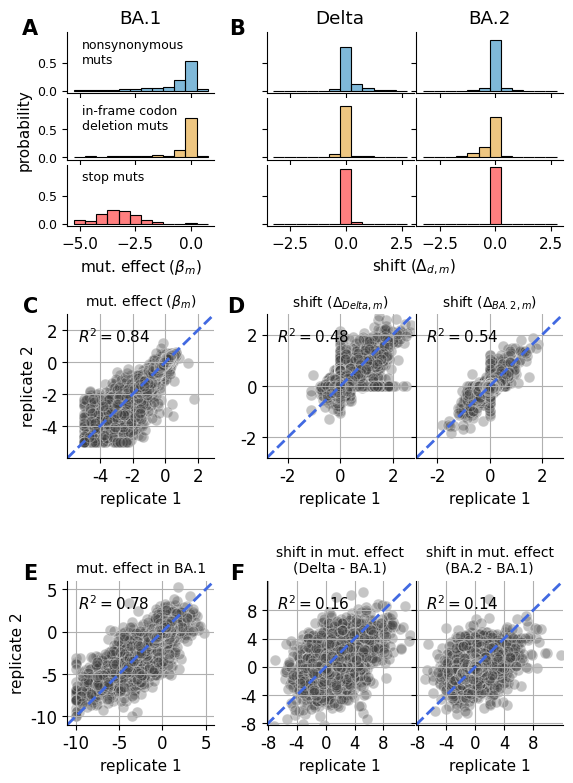

In [63]:
saveas="shift_distribution_correlation_naive"
pal = sns.color_palette('colorblind')
fig = plt.figure(figsize=[6.4, 9])

# the ratio of plot to divider between 
dist_sf = 3

# three rows of distributions
dist_rows = [[] for _ in range(3)]
for row, mut_type in enumerate(["m", "i", "n"]):
    dist_rows[row].extend([f"dist_{mut_type}_beta"]*dist_sf)
    dist_rows[row].append(".")
    for param in ["shift_Delta", "shift_Omicron_BA2"]:
        dist_rows[row].extend([f"dist_{mut_type}_{param}"]*dist_sf)

# empty space row
number_of_rows = len(dist_rows[0])
empty_row = ["."] * len(dist_rows[0])

# correlation plot row
corr_row = ["corr_beta"]*dist_sf+ ["."]
for param in ["shift_Delta", "shift_Omicron_BA2"]:
    corr_row.extend([f"corr_{param}"]*dist_sf)
    
# niave correlation plot row
naive_corr_row = ["naive_corr_Omicron_BA1_beta"]*dist_sf+ ["."]
for param in ["Delta_S", "Omicron_BA2_S"]:
    naive_corr_row.extend([f"naive_corr_{param}"]*dist_sf)

axs = fig.subplot_mosaic(
    dist_rows+[empty_row, corr_row, empty_row, naive_corr_row],
    height_ratios=[0.3, 0.3, 0.3] + [0.38, 0.7, 0.55, 0.7],
    empty_sentinel=".",
    gridspec_kw={
        "wspace": 0.05,
        "hspace": 0.05,
    }
)

query_dict = {
    "m" : "muts != '*' and muts != '-'",
    "i" : "muts == '-'",
    "n" : "muts == '*'"
}

bins_dict = {
    "beta" : np.arange(-5.25, 1.0, 0.5),
    "shift_Delta" : np.arange(-3.25, 3.25, 0.5),
    "shift_Omicron_BA2" : np.arange(-3.25, 3.25, 0.5)
}

#################
# DISTRIBUTIONS
#################
mut_df_replicates["sense"] = ["stop" if mut == "*" else "nonsynonymous" for mut in mut_df_replicates.muts]

prefix = "avg"
bins = np.arange(-5.25, 1.0, 0.5)
# df = mut_df_replicates.copy()
mut_df_replicates["avg_beta"].clip(lower=-5, inplace=True)

for col, param in enumerate(["beta", "shift_Delta", "shift_Omicron_BA2"]):
    for row, mut_type in enumerate(["m", "i", "n"]):
        
        iter_ax = axs[f"dist_{mut_type}_{param}"]
        sns.histplot(
            mut_df_replicates.query(query_dict[mut_type]), 
            x=f"{prefix}_{param}", 
            ax=iter_ax,
            stat='probability',
            bins=bins_dict[param],
            label="stop",
            color="red" if mut_type == "n" else pal.as_hex()[row],
            alpha=0.5
        )
        iter_ax.set_ylim(-0.05,1.05)
        
        # remove the ylabel from all but the first column
        if col != 0: 
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_yticks(
            [0.0, 0.5], [0.0, 0.5], rotation=0, ha="right",size=9
        )
            
        if col != 0 or row != 1:
            iter_ax.set_ylabel(None)
        else:
            iter_ax.set_ylabel("probability")
        
        # remove the x labels from all but bottom
        if row != 2:
            iter_ax.tick_params(axis='x', labelbottom=False)
            iter_ax.set_xlabel(None)

        iter_ax.set_xlabel(None)
        
        sns.despine(ax=iter_ax)
        
axs["dist_n_beta"].set_xlabel(r"mut. effect $(\beta_{m})$")
axs["dist_n_beta"].xaxis.set_label_coords(0.5, -.5)

axs["dist_m_beta"].text(
    0.1, 0.9, 
    f"nonsynonymous\nmuts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_m_beta"].transAxes
)
axs["dist_i_beta"].text(
    0.1, 0.9, 
    f"in-frame codon\ndeletion muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_i_beta"].transAxes
)
axs["dist_n_beta"].text(
    0.1, 0.9, 
    f"stop muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_n_beta"].transAxes
)

axs["dist_n_shift_Delta"].set_xlabel('shift ($\Delta_{d,m}$)')
axs["dist_n_shift_Delta"].xaxis.set_label_coords(1.0, -.5)

axs["dist_m_shift_Delta"].set_title("Delta")
axs["dist_m_shift_Omicron_BA2"].set_title("BA.2")

#################
# CORRELATIONS
#################

data = mut_df_replicates.dropna().copy()
data['1_beta'].clip(lower=-5, inplace=True)
data['2_beta'].clip(lower=-5, inplace=True)
# plot the correlations of parameters
for col, param in enumerate(["beta", "shift_Delta", "shift_Omicron_BA2"]):
    iter_ax = axs[f"corr_{param}"]
    x, y = data[f"1_{param}"], data[f"2_{param}"]
    sns.scatterplot(
        data = data,
        x = f"1_{param}",
        y = f"2_{param}",
        ax=iter_ax,
        s=60, 
        alpha=0.3,     
        c='0.25'
    )
    
    # remove y labels from all but first column
    if col != 0: 
        
        if col == 2:
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_ylabel(None)
        
        lim = [-2.8, 2.8]
        ticks = [-2, 0, 2]
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
    else:
        lim = [-6, 3]
        ticks = [-4, -2, 0, 2]
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
        iter_ax.set_ylabel("replicate 2")
        
    iter_ax.set_xlabel("replicate 1")
    iter_ax.grid()

    
    corr = pearsonr(x, y)[0]**2
    iter_ax.annotate(
        f"$R^2 = {corr:.2f}$", 
        (0.07, 0.8), 
        xycoords="axes fraction", 
        fontsize=11
    )
    sns.despine(ax=iter_ax)
    
#################
# NAIVE CORRELATIONS
#################

data = naive_mut_df.dropna().copy()
data["1-Omicron_BA1_beta"].clip(lower=-10, inplace=True)
data["2-Omicron_BA1_beta"].clip(lower=-10, inplace=True)

# plot the correlations of parameters
for col, param in enumerate(["Omicron_BA1_beta", "Delta_S", "Omicron_BA2_S"]):
    iter_ax = axs[f"naive_corr_{param}"]
    x, y = data[f"1-{param}"], data[f"2-{param}"]
    sns.scatterplot(
        data = data,
        x = f"1-{param}",
        y = f"2-{param}",
        ax=iter_ax,
        s=60, 
        alpha=0.3,     
        c='0.25'
    )
    
    # remove y labels from all but first column
    if col != 0: 
        
        if col == 2:
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_ylabel(None)
        
        lim = [-8.2, 12.2]
        ticks = range(-8, 12, 4)
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
    else:
        lim = [-11, 6]
        ticks = range(-10, 6, 5)
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
        iter_ax.set_ylabel("replicate 2")
        
    iter_ax.set_xlabel("replicate 1")
    iter_ax.grid()

    
    corr = pearsonr(x, y)[0]**2
    iter_ax.annotate(
        f"$R^{2} = {corr:.2f}$", 
        (0.07, 0.8), 
        xycoords="axes fraction", 
        fontsize=11
    )
    sns.despine(ax=iter_ax)




# Add subpanel labels
axs["dist_m_beta"].text(
    -0.2, 1.05, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["dist_m_beta"].transAxes
)


axs["dist_m_shift_Delta"].text(
    -0.15, 1.05, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["dist_m_shift_Delta"].transAxes
)

axs["corr_beta"].text(
    -0.2, 1.05, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["corr_beta"].transAxes
)

axs["corr_shift_Delta"].text(
    -0.15, 1.05, 
    f"D", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["corr_shift_Delta"].transAxes
)

axs["naive_corr_Omicron_BA1_beta"].text(
    -0.2, 1.05, 
    f"E", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["naive_corr_Omicron_BA1_beta"].transAxes
)

axs["naive_corr_Delta_S"].text(
    -0.15, 1.05, 
    f"F", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["naive_corr_Delta_S"].transAxes
)

# titles
axs["dist_m_beta"].set_title("BA.1")
axs["corr_beta"].set_title(r"mut. effect $(\beta_{m})$", size=10)
axs["corr_shift_Delta"].set_title("shift ($\Delta_{Delta, m}$)", size=10)
axs["corr_shift_Omicron_BA2"].set_title("shift ($\Delta_{BA.2, m}$)", size=10)

axs["naive_corr_Omicron_BA1_beta"].set_title("mut. effect in BA.1", size=10)
axs["naive_corr_Delta_S"].set_title("shift in mut. effect\n(Delta - BA.1)", size=10)
axs["naive_corr_Omicron_BA2_S"].set_title("shift in mut. effect\n(BA.2 - BA.1)", size=10)

fig.savefig(f"{output_dir}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{output_dir}/{saveas}.png",bbox_inches='tight')

plt.show()  

## Comparison to linear model

In [123]:
fit_params_linear = fit_params.copy()
fit_params_linear["dataset"] = datasets
fit_params_linear["epistatic_model"] = ["Identity"]

_, _, linear_models = multidms.fit_models(fit_params_linear, n_threads=-1)

In [124]:
model_collection_linear = multidms.ModelCollection(linear_models)

In [125]:
chart, sparsity_df = model_collection_linear.shift_sparsity(return_data=True, height_scalar=100) # TODO raise issue to fix height scalar
print(sparsity_df.head())
chart

cache miss - this could take a moment
  dataset_name  scale_coeff_lasso_shift       mut_type    mut_param  sparsity
0        rep-1                 0.000000  nonsynonymous  shift_Delta  0.234082
1        rep-1                 0.000000           stop  shift_Delta  0.247678
2        rep-1                 0.000005  nonsynonymous  shift_Delta  0.320816
3        rep-1                 0.000005           stop  shift_Delta  0.318885
4        rep-1                 0.000010  nonsynonymous  shift_Delta  0.413163


alt.FacetChart(...)

In [126]:
chart, corr_df = model_collection_linear.mut_param_dataset_correlation(width_scalar=200, return_data=True)
print(corr_df.head())
chart

      datasets mut_param  correlation  scale_coeff_lasso_shift
0  rep-1,rep-2      beta     0.723252                 0.000000
0  rep-1,rep-2      beta     0.742715                 0.000005
0  rep-1,rep-2      beta     0.746827                 0.000010
0  rep-1,rep-2      beta     0.737302                 0.000020
0  rep-1,rep-2      beta     0.726406                 0.000040


alt.FacetChart(...)

In [127]:
fit_params_linear["dataset"] = train 
_, _, linear_models_cv = multidms.model_collection.fit_models(fit_params_linear, n_threads = -1)

In [128]:
linear_mc = multidms.model_collection.ModelCollection(linear_models_cv)
linear_mc.add_validation_loss(test, overwrite=True)

In [132]:
cross_validation_df = linear_mc.get_conditional_loss_df()
cross_validation_df.head()

,dataset_name,scale_coeff_lasso_shift,condition,loss,split
0,rep-1,0.0,Delta,0.234156,training
1,rep-1,0.000005,Delta,0.235351,training
2,rep-1,0.00001,Delta,0.237773,training
3,rep-1,0.00002,Delta,0.244865,training
4,rep-1,0.00004,Delta,0.262903,training


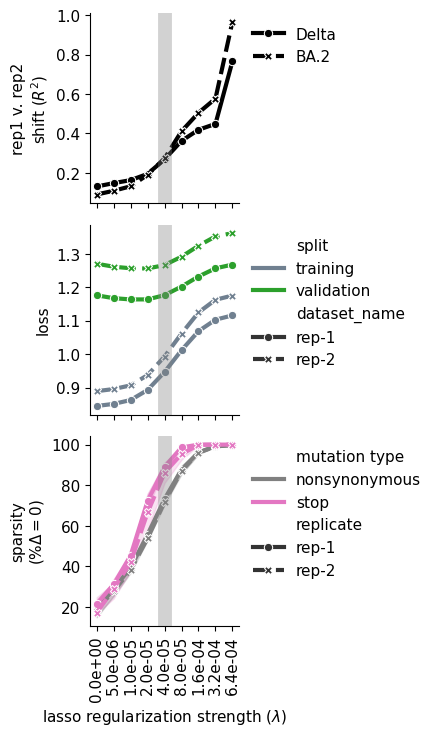

In [133]:
saveas="shrinkage_analysis_linear_models"

fig, ax = plt.subplots(3, figsize=[4.5, 7.5], sharex=True)

# replicate correlation
iter_ax = ax[0]
sns.lineplot(
    data=(
        corr_df
        .query("mut_param.str.contains('shift')")
        .rename({"mut_param":"shift params"}, axis=1)
        # .replace({"Data-1":"rep-1", "Data-2":"rep-2"})
        .replace({"shift_Delta":"Delta", "shift_Omicron_BA2":"BA.2"})
        .assign(
            scale_coeff_lasso_shift = [
                f"{l:.1e}" 
                for l in corr_df.query("mut_param.str.contains('shift')").scale_coeff_lasso_shift
            ],
            correlation = lambda x: x.correlation**2
        )
        .reset_index(drop=True)
    ),
    x="scale_coeff_lasso_shift",
    y="correlation",
    style="shift params",
    markers=True,
    ax=iter_ax,
    linewidth=3,
    color="black"
)
iter_ax.set_ylabel("rep1 v. rep2\nshift $(R^2)$")
# move legend outside of plot
iter_ax.legend(
    bbox_to_anchor = (1, 1), 
    loc='upper left', 
    frameon=False
)



# plot loss
iter_ax = ax[1]
sns.lineplot(
    data = (
        cross_validation_df.query("condition=='total'")
        .assign(
            # lasso_strength = [f"{l:.1e}" for l in sparsity_df.scale_coeff_lasso_shift]
            # lasso_strength = lambda x: f"{x.scale_coeff_lasso_shift:.1e}"
            lasso_strength = lambda x: x['scale_coeff_lasso_shift'].apply(lambda y: f'{y:.1e}')
        )
    ),
    x="lasso_strength",
    y="loss",
    ax=iter_ax,
    hue="split",
    style="dataset_name",
    palette={"training":"slategrey", "validation":"#2CA02C"},
    markers=True,
    linewidth=3
)
# move legend outside of plot
iter_ax.legend(
    bbox_to_anchor = (1, 1), 
    loc='upper left', 
    frameon=False
)


# plot sparsity
iter_ax = ax[2]
sns.lineplot(
    data=(
        sparsity_df
        .rename({"dataset_name":"replicate"}, axis=1)
        .rename({"mut_param":"shift params", "mut_type":"mutation type"}, axis=1)
        # .replace({"Data-0":"rep-1", "Data-1":"rep-2"})
        .replace({"nonsynonymous":"nonsynonymous", "stop":"stop"})
        .replace({"shift_Delta":"Delta", "shift_Omicron_BA2":"BA.2"})
        .assign(
            scale_coeff_lasso_shift = [f"{l:.1e}" for l in sparsity_df.scale_coeff_lasso_shift],
            sparsity_percent = lambda x: x.sparsity * 100,
        )
    ),
    x="scale_coeff_lasso_shift",
    y="sparsity_percent",
    hue="mutation type",
    style="replicate",
    palette={"nonsynonymous":"grey", "stop":"#E377C2"},
    markers=True,
    legend=True,
    ax=iter_ax,
    linewidth=3
)
# move legend outside of plot
iter_ax.legend(
    bbox_to_anchor = (1, 1), 
    loc='upper left', 
    frameon=False
)
# rotate x labels
iter_ax.set_xticklabels(
    iter_ax.get_xticklabels(), 
    rotation=90, 
    ha='center'
)
iter_ax.set_ylabel("sparsity\n$(\%\Delta=0)$")
iter_ax.set_xlabel(f"lasso regularization strength ($\lambda$)")

for axes in ax:
    axes.axvline(
        f"{chosen_lasso_strength:.1e}", 
        color="grey",
        linewidth=10,
        alpha=0.35
    )

sns.despine(fig)
plt.tight_layout()
# plt.tight_layout()
fig.savefig(f"{output_dir}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{output_dir}/{saveas}.png",bbox_inches='tight')
# plt.show()

plt.show()

## Validation mutations

Next, we compare the results of the model to mutations tested individually in _in-vitro_

In [117]:
mut_df_replicates = combine_replicate_muts(
    {
        f"{fit.dataset_name}".split("-")[-1]: fit.model
        for fit in models.query(f"scale_coeff_lasso_shift == {chosen_lasso_strength}").itertuples()
    },
    predicted_func_scores=True,
    phenotype_as_effect=True,
    how="inner",
    times_seen_threshold=times_seen_threshold
)
mut_df_replicates

,wts,sites,muts,1_beta,2_beta,avg_beta,1_shift_Delta,2_shift_Delta,avg_shift_Delta,1_shift_Omicron_BA2,...,avg_shift_Omicron_BA2,1_predicted_func_score_Delta,2_predicted_func_score_Delta,avg_predicted_func_score_Delta,1_predicted_func_score_Omicron_BA1,2_predicted_func_score_Omicron_BA1,avg_predicted_func_score_Omicron_BA1,1_predicted_func_score_Omicron_BA2,2_predicted_func_score_Omicron_BA2,avg_predicted_func_score_Omicron_BA2
mutation,,,,,,,,,,,,,,,,,,,,,
M1I,M,1,I,-2.924932,-4.256726,-3.590829,0.000000,0.000000,0.000000,-0.000000,...,0.000000,-3.162696,-3.348626,-3.255661,-3.009065,-3.236155,-3.122610,-3.085516,-3.409368,-3.247442
F2L,F,2,L,0.200928,0.207115,0.204021,-0.000000,-0.000000,0.000000,-0.204654,...,-0.102327,0.287689,0.366644,0.327167,0.405955,0.487242,0.446598,-0.200109,0.107339,-0.046385
F2S,F,2,S,0.194773,-0.074343,0.060215,-0.000000,0.000000,0.000000,0.000000,...,0.000000,0.275053,-0.286178,-0.005562,0.393345,-0.166355,0.113495,0.195843,-0.525584,-0.164871
F2V,F,2,V,0.239144,-0.030672,0.104236,-0.086489,-0.153066,-0.119778,0.000000,...,0.000000,0.188819,-0.521577,-0.166379,0.484417,-0.069216,0.207601,0.286191,-0.431950,-0.072880
V3A,V,3,A,-0.007044,-0.047157,-0.027101,-0.000000,-0.000000,0.000000,-0.000000,...,-0.001301,-0.133532,-0.225989,-0.179760,-0.013975,-0.106083,-0.060029,-0.206590,-0.473092,-0.339841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S1252T,S,1252,T,-0.132241,-0.189524,-0.160882,-0.000000,0.000000,0.000000,-0.074971,...,-0.037485,-0.379343,-0.533716,-0.456529,-0.258642,-0.414259,-0.336450,-0.586871,-0.763869,-0.675370
S1252V,S,1252,V,0.161672,0.177089,0.169381,0.262923,-0.185348,0.038788,-0.044192,...,-0.080998,0.750125,-0.138738,0.305693,0.325693,0.414606,0.370149,0.039893,-0.233608,-0.096858
S1252W,S,1252,W,0.046494,0.283281,0.164887,0.000000,0.000000,0.000000,0.018787,...,-0.015843,-0.026414,0.553441,0.263513,0.092733,0.674209,0.383471,-0.064218,0.168365,0.052073


In [118]:
mut_df = (
    mut_df_replicates
    .assign(
        phenotypic_effect_Delta = 2**mut_df_replicates["avg_predicted_func_score_Delta"],
        phenotypic_effect_Omicron_BA2 = 2**mut_df_replicates["avg_predicted_func_score_Omicron_BA2"],
        phenotypic_effect_Omicron_BA1 = 2**mut_df_replicates["avg_predicted_func_score_Omicron_BA1"]
    )
    .reset_index()
)
mut_df[[c for c in mut_df.columns if "phenotypic_effect" in c]].describe()

,phenotypic_effect_Delta,phenotypic_effect_Omicron_BA2,phenotypic_effect_Omicron_BA1
count,5934.000000,5934.000000,5934.000000
mean,0.685844,0.555077,0.691773
std,0.333441,0.300639,0.398528
min,0.092687,0.094148,0.101826
25%,0.468865,0.278595,0.306873
50%,0.742053,0.595659,0.748459
75%,0.909277,0.786314,0.983936
max,4.126436,2.176377,2.776442


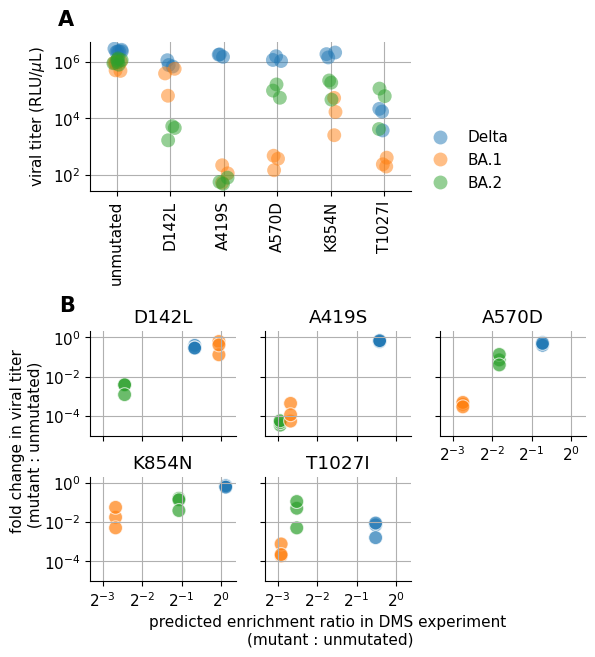

In [120]:
saveas="validation_titer_fold_change"

row1 = ['titer', 'titer', '.']
row2 = ['D142L', 'A419S', 'A570D'] 
row3 = ['K854N', 'T1027I', 'legend']
empty_row = ["."] * 3

fig = plt.figure( figsize=[6.4, 7])
axs = fig.subplot_mosaic(
    [row1, empty_row, row2, row3],
    height_ratios=[
        1, 0.39, 0.7, 0.7
    ],
    empty_sentinel=".",
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)

#############
# TITERS
#############

# Read in data
titers_df = pd.read_csv('data/viral_titers.csv')
titers_df.rename(
    columns={'RLUperuL':'titer', 'background':'homolog'},
    inplace=True
)

# Add a column giving the replicate and mutation
titers_df['replicate'] = titers_df['virus'].apply(lambda x: x[-1])
titers_df['mutation'] = titers_df['virus'].str.extract(r'_(\S+)_')
titers_df['mutation'].fillna('unmutated', inplace=True)
titers_df['mutation'].replace('142L', 'D142L', inplace=True)

# Plot data for a given mutation
validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
homologs = ['Delta', 'BA.1', 'BA.2']
replicates = ['1', '2', '3']
xticklabels = ['unmutated'] + validation_mutations
pal = sns.color_palette('colorblind')
hex_codes = pal.as_hex()
for (i, homolog) in enumerate(homologs):
    
    data = titers_df[(titers_df['homolog'] == homolog)]
    
    sns.stripplot(
        x='mutation', y='titer', data=data, ax=axs['titer'],
        order=xticklabels, s=10, alpha=0.5,
        hue='homolog', hue_order=['Delta', 'BA.1', 'BA.2'],
    )
    sns.boxplot(
        x='mutation', y='titer', data=data, ax=axs['titer'],
        order=xticklabels,
        showfliers=False, showbox=False, showcaps=False,
        medianprops={'visible': False}, #dict(color=hex_codes[i]),
        whiskerprops={'visible': False},
    )

handles, labels = axs['titer'].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs['titer'].legend(by_label.values(), by_label.keys(), bbox_to_anchor=[1,0.5])

axs['titer'].set_yscale('log')
axs['titer'].set_yticks([1e2, 1e4, 1e6])
axs['titer'].set_xticklabels(axs['titer'].get_xticklabels(), rotation = 90)
axs['titer'].set_ylabel(r'viral titer (RLU/$\mu$L)')
axs['titer'].set_xlabel('')
axs['titer'].grid()
sns.despine(ax = axs['titer'])


#############
# FOLD CHANGE
#############

# Read in data
val_df = pd.read_csv('data/spike_validation_data.csv')

# Restructure the data
val_dict = {
    key : []
    for key in [
        'mutation', 'fold_change', 'homolog', 'replicate',
        'predicted_beta'
    ]
}
validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
for i, row in val_df.iterrows():
    for mutation in validation_mutations:
        homolog = row['background'].replace('.', '')
        homolog = "Omicron_" + homolog if "BA" in homolog else homolog

        val_dict['mutation'].append(mutation)
        val_dict['fold_change'].append(row[mutation])
        val_dict['homolog'].append(homolog)
        val_dict['replicate'].append(row['replicate'])

        predicted_beta = float(mut_df[
            mut_df['mutation'] == mutation
        ][f'phenotypic_effect_{homolog}'].values[0])
        val_dict['predicted_beta'].append(predicted_beta)

val_df = pd.DataFrame(val_dict)
val_df['site'] = val_df['mutation'].apply(lambda x: int(x[1:-1]))
val_df['homolog'].replace('Omicron_BA1', 'BA.1', inplace=True)
val_df['homolog'].replace('Omicron_BA2', 'BA.2', inplace=True)
val_df.sort_values('site', inplace=True)

for (i, mutation) in enumerate(validation_mutations):
    data = val_df[val_df['mutation'] == mutation]
    iter_ax = axs[mutation]
    sns.scatterplot(
        x='predicted_beta', y='fold_change', data=data,
        hue='homolog', ax=iter_ax, s=100, alpha=0.7,
        hue_order=['Delta', 'BA.1', 'BA.2']
    )
    iter_ax.set(
        title=mutation, xlabel='', ylabel='',
        yscale='log', ylim=[1e-5,2], yticks=[1, 1e-2, 1e-4],
    )
    iter_ax.set_xscale('log', base=2)
    iter_ax.set_xlim([0.1, 1.3])
    iter_ax.set_xticks([2**-3, 2**-2, 2**-1, 2**0])

    iter_ax.grid()
    iter_ax.get_legend().remove()
    sns.despine(ax=iter_ax)
    
    if mutation in ['D142L', 'A419S']:
        iter_ax.tick_params(axis="x", labelbottom=False)
    
    if mutation not in ['D142L', 'K854N']:
        iter_ax.tick_params(axis="y", labelleft=False)

fig.text(
    0.5, 0.02, "predicted enrichment ratio in DMS experiment \n(mutant : unmutated)",
    ha='center'
)
fig.text(
    0.000, 0.31, 'fold change in viral titer\n (mutant : unmutated)',
    va='center', rotation='vertical'
)
axs["legend"].set_axis_off()

axs["titer"].text(
    -0.05, 1.15, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["titer"].transAxes
)
axs["D142L"].text(
    -0.1, 1.25, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["D142L"].transAxes
)

fig.savefig(f"{output_dir}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{output_dir}/{saveas}.png",bbox_inches='tight')
plt.show()

## Model-reference choice comparison

Here, we fit each of the replicate dataset as before, but we also fit models where using Delta and BA.2 as a reference to show the model is robust to choice of reference 

In [79]:
variable_reference_datasets = []

for reference in ["Delta", "Omicron_BA1", "Omicron_BA2"]:
    for replicate, rep_fsdf in func_score_df.groupby("replicate"):
        
        start = time.time()

        # initialize data object
        data = multidms.Data(
            rep_fsdf,
            collapse_identical_variants="mean",
            alphabet=multidms.AAS_WITHSTOP_WITHGAP,
            reference=reference,
            assert_site_integrity=False,
            verbose=True,
            nb_workers=16,
            name=f"{replicate}-{reference}"
        )
        data.condition_colors = cc
        variable_reference_datasets.append(data)


inferring site map for Delta


  0%|          | 0/28515 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/70597 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/60397 [00:00<?, ?it/s]

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [144, 143, 69, 145, 70, 211, 25, 26, 24, 157, 158, 898],
dropping: 10983 variantswhich have mutations at those sites.


invalid non-identical-sites: [371, 376], dropping 3499 variants
Converting mutations for Delta
is reference, skipping
Converting mutations for Omicron_BA1


Converting mutations for Omicron_BA2


inferring site map for Delta


  0%|          | 0/29158 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/62129 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/57719 [00:00<?, ?it/s]

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [145, 70, 144, 143, 69, 211, 422, 26, 24, 25, 157, 158],
dropping: 10129 variantswhich have mutations at those sites.


invalid non-identical-sites: [371], dropping 1873 variants
Converting mutations for Delta
is reference, skipping
Converting mutations for Omicron_BA1


Converting mutations for Omicron_BA2


inferring site map for Delta


  0%|          | 0/28515 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/70597 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/60397 [00:00<?, ?it/s]

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [144, 143, 69, 145, 70, 211, 25, 26, 24, 157, 158, 898],
dropping: 10983 variantswhich have mutations at those sites.


invalid non-identical-sites: [371], dropping 2041 variants
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


inferring site map for Delta


  0%|          | 0/29158 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/62129 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/57719 [00:00<?, ?it/s]

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [145, 70, 144, 143, 69, 211, 422, 26, 24, 25, 157, 158],
dropping: 10129 variantswhich have mutations at those sites.


invalid non-identical-sites: [371], dropping 1873 variants
Converting mutations for Delta


Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2


inferring site map for Delta


  0%|          | 0/28515 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/70597 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/60397 [00:00<?, ?it/s]

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [144, 143, 69, 145, 70, 211, 25, 26, 24, 157, 158, 898],
dropping: 10983 variantswhich have mutations at those sites.


invalid non-identical-sites: [376], dropping 1486 variants
Converting mutations for Delta


Converting mutations for Omicron_BA1


Converting mutations for Omicron_BA2
is reference, skipping
inferring site map for Delta


  0%|          | 0/29158 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/62129 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/57719 [00:00<?, ?it/s]

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


unknown cond wildtype at sites: [145, 70, 144, 143, 69, 211, 422, 26, 24, 25, 157, 158],
dropping: 10129 variantswhich have mutations at those sites.


invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Delta


Converting mutations for Omicron_BA1


Converting mutations for Omicron_BA2
is reference, skipping


In [80]:
variable_reference_fit_params = fit_params.copy()
variable_reference_fit_params["dataset"] = variable_reference_datasets
variable_reference_fit_params["scale_coeff_lasso_shift"] = [chosen_lasso_strength]
_, _, variable_reference_models = multidms.fit_models(variable_reference_fit_params, n_threads=-1)

In [86]:
variable_reference_models = (
    variable_reference_models
    .assign(
        reference=lambda x: x.dataset_name.str.split("-").str[-1],
        replicate=lambda x: x.dataset_name.str.split("-").str[0]
    )
)

For each of the reference fits, compute parameters relative to a BA.1 reference

In [87]:
relative_params = pd.DataFrame()
homologs = ["Delta", "Omicron_BA1", "Omicron_BA2"]

# For each respective model fit 
for reference, replicate_models in variable_reference_models.groupby("reference"):
    
    # combine the replicate mutational 
    mut_df = combine_replicate_muts(
        {
            f"rep_{row.replicate}":row["model"] 
            for idx, row in replicate_models.iterrows()
        },
        times_seen_threshold = times_seen_threshold
    )
    
    mut_df = mut_df.copy()[[c for c in mut_df.columns if "avg" in c]]
    
    # Compute mut effect (beta+shift) relative to each homolog
    for homolog in homologs:
        if homolog == reference:
            mut_df[f"beta_{homolog}"] = mut_df["avg_beta"]
        else:
            mut_df[f"beta_{homolog}"] = mut_df["avg_beta"] + mut_df[f"avg_shift_{homolog}"]
       
    # Compute shifts relative to BA1 (betas_h - beta_BA1)
    for homolog in homologs:
        mut_df[f"shift_{homolog}"] = mut_df[f"beta_{homolog}"] - mut_df[f"beta_Omicron_BA1"]
    
    # drop un-neccessary columns
    mut_df.drop([c for c in mut_df.columns if "avg" in c], axis=1, inplace=True)
    
    mut_df = mut_df.assign(reference = reference)
    
    relative_params = pd.concat([relative_params, mut_df])

    
relative_params.drop(["beta_Delta", "beta_Omicron_BA2", "shift_Omicron_BA1"], axis=1, inplace=True)
relative_params.reference.replace({"Omicron_BA2":"BA2", "Omicron_BA1": "BA1"}, inplace=True)
relative_params

,beta_Omicron_BA1,shift_Delta,shift_Omicron_BA2,reference
mutation,,,,
M1I,-3.362432,0.000000,0.000000,Delta
F2L,0.232434,0.000000,-0.066369,Delta
F2S,0.142001,0.000000,0.000000,Delta
F2V,0.277621,0.000000,0.000000,Delta
V3A,-0.026383,-0.045533,-0.045533,Delta
...,...,...,...,...
S1252T,-0.155242,-0.036178,-0.036178,BA2
S1252V,0.166300,0.030589,-0.078923,BA2
S1252W,0.165440,0.014676,0.014676,BA2


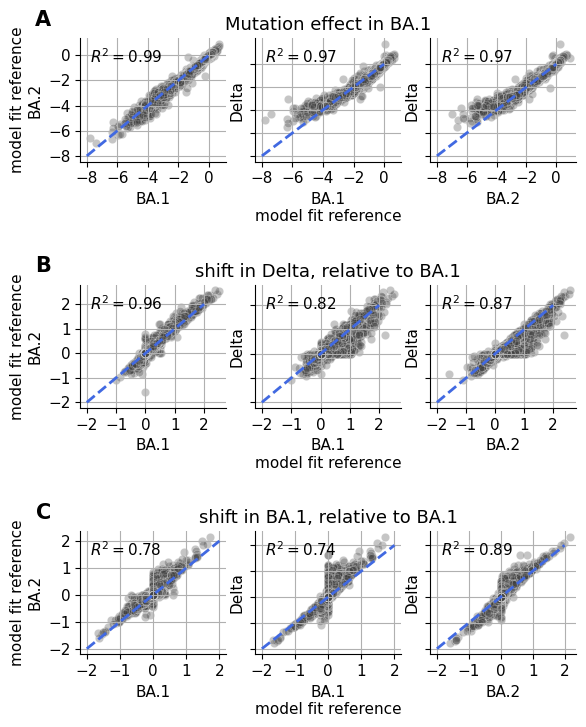

In [89]:
saveas = "reference_model_comparison_params_scatter"
parameters = ["beta_Omicron_BA1", "shift_Delta", "shift_Omicron_BA2"]


fig = plt.figure( figsize=[6.4, 8])
axs = fig.subplot_mosaic(
    [[f"{param}_{col}" for col in range(3)] for param in parameters],
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 1.0,
    }
)

param_limits = {
    "beta_Omicron_BA1" : range(-8, 2, 2),
    "shift_Delta" : range(-2, 3),
    "shift_Omicron_BA2" : range(-2, 3) 
}

param_titles = {
    "beta_Omicron_BA1" : r"Mutation effect in BA.1",
    "shift_Delta" : "shift in Delta, relative to BA.1",
    "shift_Omicron_BA2" : "shift in BA.1, relative to BA.1"
}


for row, param in enumerate(parameters):
    
    # pivot to each fit on columns, drop NIS.
    data = relative_params.pivot(
        columns = "reference",
        values = param
    ).dropna()

    # plot each combination of fits
    for col, (x, y) in enumerate(combinations(data.columns, 2)):
        iter_ax = axs[f"{param}_{col}"]
        
        sns.scatterplot(
            data = data,
            x = x,
            y = y,
            ax = iter_ax,
            alpha=0.3,
            c='0.25'
        )
        
        corr = pearsonr(data[x], data[y])[0]**2
        iter_ax.annotate(
            f"$R^2 = {corr:.2f}$", 
            (0.07, 0.8), 
            xycoords="axes fraction", 
            fontsize=11
        )
        
        limits = param_limits[param]
        iter_ax.set_yticks(limits)
        iter_ax.set_xticks(limits)
        mmin, mmax = min(limits), max(limits)
        iter_ax.plot([mmin, mmax], [mmin, mmax], "--", lw=2, c="royalblue")
        label_fn = lambda x: x if x == "Delta" else f"{x[0]}{x[1]}.{x[2]}"
        
        
        xl = f"{label_fn(x)}"
        yl = f"{label_fn(y)}"
        if col == 1: xl += "\nmodel fit reference"
        if col == 0: yl = "model fit reference\n" + yl
        iter_ax.set_xlabel(xl)
        iter_ax.set_ylabel(yl)            
            
        
        
        iter_ax.grid()
        sns.despine(ax = iter_ax)
        
        if col != 0:
            iter_ax.tick_params("y", labelleft=False)
            
        if col == 1:
            iter_ax.set_title(param_titles[param], size=13)
            


for param, sub_anno in zip(parameters, ["A", "B", "C"]):
    iter_ax = axs[f"{param}_0"]    
    axs[f"{param}_0"].text(
        -0.2, 1.15, 
        sub_anno, 
        ha="right", va="center", 
        size=15,
        weight="bold",
        transform=iter_ax.transAxes
    )

fig.savefig(f"{output_dir}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{output_dir}/{saveas}.png",bbox_inches='tight')
plt.show()

## Cumulative distribution of model sparsity

In [97]:
tall_mut_df_chosen = (
    mc.split_apply_combine_muts(query=f"scale_coeff_lasso_shift == {chosen_lasso_strength}", times_seen_threshold=times_seen_threshold)
    .reset_index()
    .rename(columns={"dataset_name":"replicate"})
    .assign(sense=lambda x: ["stop" if "*" in mut else "nonsynonymous" for mut in x.mutation])
    .melt(
        id_vars=["replicate", "mutation", "sense"],
        value_vars=["shift_Delta", "shift_Omicron_BA2"],
        var_name="condition",
        value_name="shift"
    )
    .replace({"shift_Delta":"Delta", "shift_Omicron_BA2":"Omicron_BA2"})
)
tall_mut_df_chosen

,replicate,mutation,sense,condition,shift
0,rep-1,A1015D,nonsynonymous,Delta,0.316587
1,rep-1,A1015S,nonsynonymous,Delta,0.000000
2,rep-1,A1015T,nonsynonymous,Delta,0.117340
3,rep-1,A1016D,nonsynonymous,Delta,0.000000
4,rep-1,A1016S,nonsynonymous,Delta,-0.081105
...,...,...,...,...,...
25609,rep-2,Y917C,nonsynonymous,Omicron_BA2,0.000000
25610,rep-2,Y917F,nonsynonymous,Omicron_BA2,-0.001024
25611,rep-2,Y917H,nonsynonymous,Omicron_BA2,0.000000
25612,rep-2,Y91C,nonsynonymous,Omicron_BA2,0.000000


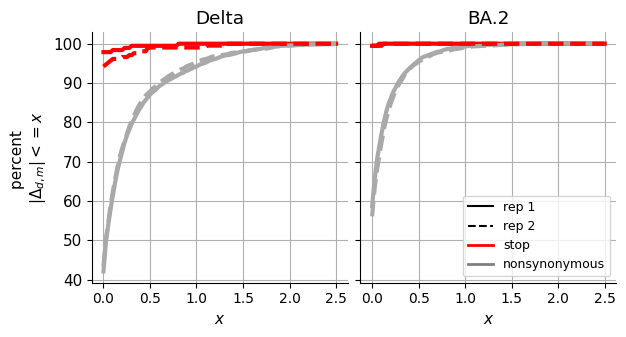

In [99]:
saveas = "percent_shifts_under_x_lineplot"
fig, ax = plt.subplots(1,2, figsize=[6.4,3.5], sharey='row')

condition_col = {
    "Delta" : 0,
    "Omicron_BA2" : 1
}

replicate_line_style = {
    "rep-1" : "-",
    "rep-2" : "--"
}

sense_colors = {
    "nonsynonymous" : "darkgrey",
    "stop" : "red"
}

t_points = np.linspace(0, 2.5, 100)
def perc_abs_lte(x, t):
    abs_x = np.abs(x)
    return len(abs_x[abs_x<=t]) / len(x) #)*100

for (condition, replicate, sense), mut_df_replicates in tall_mut_df_chosen.groupby(["condition", "replicate", "sense"]):
    iter_ax = ax[condition_col[condition]]
    lt_percentages = [perc_abs_lte(mut_df_replicates["shift"], t)*100 for t in t_points]
    iter_ax.plot(
        t_points, 
        lt_percentages,
        linestyle = replicate_line_style[replicate],
        color = sense_colors[sense],
        linewidth = 3
    )
    iter_ax.set_xticks(np.linspace(0,2.5,6),np.linspace(0,2.5,6), rotation=0, ha="center",size=10)
    sns.despine(ax=iter_ax)
    iter_ax.grid(visible=True)
    
ax[condition_col["Delta"]].set_title("Delta")
ax[condition_col["Omicron_BA2"]].set_title("BA.2")

ax[0].set_ylabel("percent \n$|\Delta_{d,m}| <= x$")
ax[0].set_xlabel("$x$")
ax[1].set_xlabel("$x$")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='nonsynonymous')
ax[1].legend(
    handles=[black_line, black_dashed, red_line, grey_line], 
    bbox_to_anchor = (1, 0), 
    loc='lower right', 
    frameon=True, 
    fontsize=9
)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig(f"{output_dir}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{output_dir}/{saveas}.png",bbox_inches='tight')
plt.show()

## Correlation of BA2 and Delta Shifts

In [103]:
mut_df_replicates = (
    combine_replicate_muts(
        {
            f"{fit.dataset_name}".split("-")[-1]: fit.model
            for fit in models.query(f"scale_coeff_lasso_shift == {chosen_lasso_strength}").itertuples()
        },
        times_seen_threshold=times_seen_threshold,
        how="inner"
    )
    .assign(
        sense=lambda x: ["stop" if "*" in mut else "nonsynonymous" for mut in x.muts]
    )
)
mut_df_replicates.head()

,wts,sites,muts,1_beta,2_beta,avg_beta,1_shift_Delta,2_shift_Delta,avg_shift_Delta,1_shift_Omicron_BA2,2_shift_Omicron_BA2,avg_shift_Omicron_BA2,sense
mutation,,,,,,,,,,,,,
M1I,M,1,I,-2.924932,-4.256726,-3.590829,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,nonsynonymous
F2L,F,2,L,0.200928,0.207115,0.204021,-0.000000,-0.000000,0.000000,-0.204654,0.000000,-0.102327,nonsynonymous
F2S,F,2,S,0.194773,-0.074343,0.060215,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,nonsynonymous
F2V,F,2,V,0.239144,-0.030672,0.104236,-0.086489,-0.153066,-0.119778,0.000000,0.000000,0.000000,nonsynonymous
V3A,V,3,A,-0.007044,-0.047157,-0.027101,-0.000000,-0.000000,0.000000,-0.000000,-0.002601,-0.001301,nonsynonymous


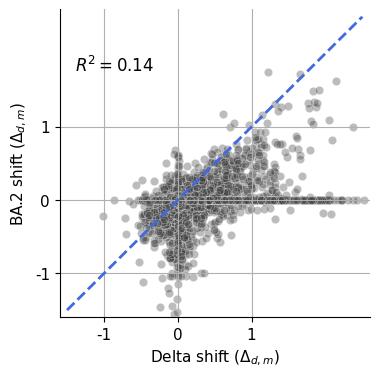

In [106]:
# data = mut_df_replicates.dropna()
saveas="shift_corr_Delta_BA2"
fig, ax = plt.subplots(1,figsize=[4,4])
lim = [-1.6, 2.6]
ticks = range(-1, 2)
sns.scatterplot(
    data=mut_df_replicates,
    x="avg_shift_Delta",
    y="avg_shift_Omicron_BA2",
#     hue = "sense",
    alpha = 0.35,
    ax=ax,
    c='0.25'
)
ax.plot()
ax.plot(
    [-1.5, 2.5], 
    [-1.5, 2.5],
    linestyle="--", 
    lw=2,
    c='royalblue'
)
corr = pearsonr(mut_df_replicates["avg_shift_Delta"], mut_df_replicates["avg_shift_Omicron_BA2"])[0]**2
ax.annotate(
    f"$R^2 = {corr:.2f}$", 
    (0.05, 0.8), 
    xycoords="axes fraction", 
    fontsize=12
)
ax.set_ylim(lim)
ax.set_xlim(lim)
ax.set_yticks(ticks, labels=ticks)
ax.set_xticks(ticks, labels=ticks)
ax.set_ylabel("BA.2 shift ($\Delta_{d,m}$)")
ax.set_xlabel("Delta shift ($\Delta_{d,m}$)")
# ax.set(xticks=np.linspace(-1.5, 2.5, 5))
ax.grid()
sns.despine(ax=ax)

fig.savefig(f"{output_dir}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{output_dir}/{saveas}.png",bbox_inches='tight')
plt.show()

## Structural Analysis



In [108]:
# mut_df_replicates = pd.read_csv(f"{output_dir}/mutations_df.csv")
mut_df_replicates.rename(
    columns={
        col : col.replace('Omicron_BA2', 'BA2')
        for col in mut_df_replicates
    }, 
    inplace=True
)

# mut_df_replicates

In [109]:
mut_df_replicates

,wts,sites,muts,1_beta,2_beta,avg_beta,1_shift_Delta,2_shift_Delta,avg_shift_Delta,1_shift_BA2,2_shift_BA2,avg_shift_BA2,sense
mutation,,,,,,,,,,,,,
M1I,M,1,I,-2.924932,-4.256726,-3.590829,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,nonsynonymous
F2L,F,2,L,0.200928,0.207115,0.204021,-0.000000,-0.000000,0.000000,-0.204654,0.000000,-0.102327,nonsynonymous
F2S,F,2,S,0.194773,-0.074343,0.060215,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,nonsynonymous
F2V,F,2,V,0.239144,-0.030672,0.104236,-0.086489,-0.153066,-0.119778,0.000000,0.000000,0.000000,nonsynonymous
V3A,V,3,A,-0.007044,-0.047157,-0.027101,-0.000000,-0.000000,0.000000,-0.000000,-0.002601,-0.001301,nonsynonymous
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S1252T,S,1252,T,-0.132241,-0.189524,-0.160882,-0.000000,0.000000,0.000000,-0.074971,-0.000000,-0.037485,nonsynonymous
S1252V,S,1252,V,0.161672,0.177089,0.169381,0.262923,-0.185348,0.038788,-0.044192,-0.117804,-0.080998,nonsynonymous
S1252W,S,1252,W,0.046494,0.283281,0.164887,0.000000,0.000000,0.000000,0.018787,-0.050473,-0.015843,nonsynonymous


Compute site-wise summary statistics

In [110]:
cols_to_collapse = [col for col in mut_df_replicates.columns if "avg_" in col]
cols_to_collapse.extend(['sites']) #, 'BA1_wt', 'BA2_wt', 'Delta_wt', 'is_BA2_wt', 'is_Delta_wt'])
shifts_by_site = mut_df_replicates[cols_to_collapse].groupby("sites").agg(
    max_abs_S_BA2 = ('avg_shift_BA2', lambda x: np.max(np.abs(x))),
    max_abs_S_Delta = ('avg_shift_Delta', lambda x: np.max(np.abs(x))),
    
    mean_abs_S_BA2 = ('avg_shift_BA2', lambda x: np.mean(np.abs(x))),
    mean_abs_S_Delta = ('avg_shift_Delta', lambda x: np.mean(np.abs(x))),
    
    mean_S_BA2 = ('avg_shift_BA2', np.mean),
    mean_S_Delta = ('avg_shift_Delta', np.mean),
    
    sum_S_BA2 = ('avg_shift_BA2',  np.sum),
    sum_S_Delta = ('avg_shift_Delta', np.sum),
)

shifts_by_site.reset_index(inplace=True)
shifts_by_site["res_n"] = shifts_by_site["sites"].astype(int)
shifts_by_site.head()

,sites,max_abs_S_BA2,max_abs_S_Delta,mean_abs_S_BA2,mean_abs_S_Delta,mean_S_BA2,mean_S_Delta,sum_S_BA2,sum_S_Delta,res_n
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,2,0.102327,0.119778,0.034109,0.039926,-0.034109,-0.039926,-0.102327,-0.119778,2
2,3,0.115220,0.104436,0.042435,0.017570,0.033281,0.017242,0.199683,0.103452,3
3,4,0.060115,0.107191,0.023524,0.052339,-0.023524,-0.019122,-0.070573,-0.057365,4
4,5,0.686307,0.291834,0.089656,0.090932,0.041643,-0.086132,0.707937,-1.464238,5


Read alignment of homologs, identify nonidentical sites in Delta and BA.2 relative to BA.1, using WH1 as the numbering reference, and add to data frame with site-level data.

In [111]:
# Read in alignment
alignment_file = 'data/clustalo-I20230702-193723-0021-19090519-p1m.clustal_num'
align_dict = {}
with open(alignment_file) as handle:
    for record in SeqIO.parse(handle, "clustal"):
        align_dict[record.id] = record.seq
        
# Identify non-identical sites realtive to BA.1
ref_seq = align_dict['WH1_QHD43416.1']
homologs = ['Delta', 'BA.2']
align_nis_dict = {
    homolog : []
    for homolog in homologs
}
align_gaps_dict = {
    homolog : []
    for homolog in homologs
}
for homolog in homologs:
    print(homolog)
    ref_n = 1
    n_diffs = 0
    for (n, (ref, i, j)) in enumerate(zip(ref_seq, align_dict['BA.1'], align_dict[homolog])):
        if i != j:
            
            # If the mut is an indel, then record it in the gap dict
            if (i == '-' or j == '-'):
                if True: # ref_n not in align_gaps_dict[homolog]:
                    align_gaps_dict[homolog].append(ref_n)
                pass # continue
            
            # Record the mut in the nis dict
            #print(ref_n, i, j)
            align_nis_dict[homolog].append(ref_n)
            n_diffs += 1
        if ref != '-':
            ref_n += 1
    print('n_diffs', n_diffs, 1-round(n_diffs/1254, 4))
    
# Add columns to shifts_by_site that indicate if a site is nonidentical
for homolog in ['Delta', 'BA.2']:
    hn = homolog.replace('.', '')
    shifts_by_site[f"is_{hn}_nis"] = shifts_by_site['res_n'].apply(lambda x: x in align_nis_dict[homolog])

Delta
n_diffs 43 0.9657
BA.2
n_diffs 27 0.9785


Define function for getting distance matrix from structure.

In [112]:
def get_distance_matrix(structure, d_metric='interatomic'):

    # Get a list of residues, ignorning heteroatoms
    residues = [r for r in structure.get_residues() if r.get_id()[0] == " "]
    res_ns = []
    res_ids = []
    for res in residues:
        full_id = res.get_full_id()
        chain = full_id[2]
        res_n = ''.join(map(str, full_id[3][1:])).strip()
        if (res_n not in res_ns) and chain == 'A':
            res_ns.append(res_n)
        res_ids.append(f'{chain}_{res_n}')
        
    # Compute a distance matrix between all pairs of C-alpha carbons
    dist_dict = {
        key : []
        for key in ['res_n', 'res_id'] + res_ids
    }
    for res_i in residues:
        full_id_i = res_i.get_full_id()
        chain_i = full_id_i[2]
        res_n_i = ''.join(map(str, full_id_i[3][1:])).strip()
        dist_dict['res_n'].append(res_n_i)
        dist_dict['res_id'].append(f'{chain_i}_{res_n_i}')
        
        #print(res_n_i)
        
        for res_j in residues:
            full_id_j = res_j.get_full_id()
            chain_j = full_id_j[2]
            res_n_j = ''.join(map(str, full_id_j[3][1:])).strip()
            
            if d_metric == 'CA':
                xyz_i = res_i["CA"].get_coord()
                xyz_j = res_j["CA"].get_coord()
                d = np.linalg.norm(xyz_j-xyz_i)

            elif d_metric == 'interatomic':
                interatomic_dists = []
                for atom_i in res_i:
                    for atom_j in res_j:
                        interatomic_dists.append(atom_i-atom_j)
                d = min(interatomic_dists)
            
            else:
                raise ValueError(f'{d_metric} not recognized')
            
            dist_dict[f'{chain_j}_{res_n_j}'].append(d)
    dist_df = pd.DataFrame(dist_dict)
    
    return dist_df

For each input PDB, compute a distance matrix that quantifies the minimum inter-atomic distance between all atom pairs from a given pair of residues. Since this takes a long time, save the results to a file and only rerun if the file doesn't exist.

In [113]:
# Make a list of PDBs to analyze, one per spike conformation
pdbs = ['7tf8', '7tl9', '7tge']

# Loop over PDBs and compute distance matrices for each
dfs = []
for pdb in pdbs:

    # Download structure
    print(pdb)
    pdbl = PDBList()
    pdbl.retrieve_pdb_file(pdb, pdir='results/', file_format='pdb')
    shutil.copy(f'results/pdb{pdb}.ent', f'results/pdb{pdb}.pdb')

    # Read in structure
    parser = PDBParser()
    structure = parser.get_structure(pdb, f'results/pdb{pdb}.ent')
    
    # Compute distance matrix and write to output file
    output_file = os.path.join(output_dir, f'{pdb}_dist_matrix.csv')
    if not os.path.isfile(output_file):
        mut_df_replicates = get_distance_matrix(structure, d_metric='interatomic')
        print(f'Writing distance matrix for {pdb} to {output_file}')
        mut_df_replicates.to_csv(output_file, index=False)

7tf8
Writing distance matrix for 7tf8 to results/spike_analysis/7tf8_dist_matrix.csv
7tl9
Writing distance matrix for 7tl9 to results/spike_analysis/7tl9_dist_matrix.csv
7tge
Writing distance matrix for 7tge to results/spike_analysis/7tge_dist_matrix.csv


Read in the distance matrices generated above. Then make an NxN matrix with the minimum distance between each pair of residues, considering all instances of a residue in a given trimer, and across all conformations being analyzed. Finally, Compute summary statistics quantifying the level of shifts in a neighborhood around a residue and compute the nearest distance to a non-identical site.

In [115]:
# Read in data
dfs = []
for pdb in pdbs:
    output_file = os.path.join(output_dir, f'{pdb}_dist_matrix.csv')
    mut_df_replicates = pd.read_csv(output_file)
    dfs.append(mut_df_replicates)
dist_df = pd.concat(dfs)

# Ignore subset of sites
dist_df = dist_df[
    ~dist_df['res_n'].isin(['214A', '214B', '214C'])
].copy()
dist_df['res_n'] = dist_df['res_n'].astype(int)

# First, collapse rows by site (ignoring chain),
# taking the min value across common entries
min_dist_df = dist_df.groupby('res_n').min()
min_dist_df.index.name = None
del min_dist_df['res_id']

# Then, transpose the dataframe and do that same
# as above, ignoring the same subset as above
min_dist_df = min_dist_df.T
min_dist_df['res_n'] = min_dist_df.apply(
    lambda row: row.name[2:],
    axis=1
)
min_dist_df = min_dist_df[
    ~min_dist_df['res_n'].isin(['214A', '214B', '214C'])
].copy()
min_dist_df['res_n'] = min_dist_df['res_n'].astype(int)

min_dist_df = min_dist_df.groupby('res_n').min()
print(len(min_dist_df.columns.values), len(min_dist_df.index))
res_ns = sorted(min_dist_df.index.unique())
# Merge per-site data with distance matrix
data = shifts_by_site.merge(
    min_dist_df, on='res_n', how='inner'
)
print(len(shifts_by_site), len(min_dist_df), len(data))

# For each site, compute the average metric among
# all neighbors
metric_prefix ="max_abs_S"
nbr_dist_cutoff = 5
print(f'Using a neighbor distance cutoff of {nbr_dist_cutoff} Angstroms')
metrics = [f'{metric_prefix}_{h}' for h in ['Delta', 'BA2']]
nbr_score_dict = {
    key : []
    for key in ['res_n', 'n_nbrs'] + [f'nbr_{metric}' for metric in metrics]
}
for res_n in list(set(res_ns)):
    nbr_data = data[
        (data[res_n] < nbr_dist_cutoff) &
        (data['res_n'] != res_n)
    ]
    nbr_score_dict['res_n'].append(res_n)
    nbr_score_dict['n_nbrs'].append(len(nbr_data))
    for metric in metrics:
        nbr_score_dict[f'nbr_{metric}'].append(nbr_data[metric].mean())

nbr_score_df = pd.DataFrame(nbr_score_dict)
nbr_score_df = nbr_score_df.merge(data, on='res_n')

for homolog in ['BA2', 'Delta']:
    
    # Get a list of non-identical sites
    nis = nbr_score_df.query(f"is_{homolog}_nis == True")["res_n"]
    
    # Add a column that gives the minimum distance to non-identical
    # sites for a given homolog, not counting the query site, which
    # we achieve by ignoring entries of 0 in the distance matrix
    nbr_score_df[f"dist_nearest_{homolog}_nis"] = nbr_score_df.replace(0, np.nan)[nis].min(axis=1)

1050 1050
1224 1050 1033
Using a neighbor distance cutoff of 5 Angstroms


Make plots analyzing the distribution shifts on the structure

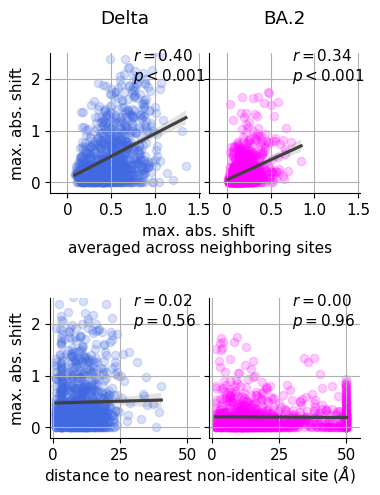

In [116]:
saveas=f"structural_statistics_{metric_prefix}"

fig = plt.figure(figsize=[4, 5])
axs = fig.subplot_mosaic(
    """
    bbbBBB
    cccCCC
    """,
    gridspec_kw={
        "hspace": 0.75,
    }
)

for homolog, iter_ax in zip(["Delta", "BA2"], ["b", "B"]):

    sns.regplot(
        data = nbr_score_df,
        y = f"{metric_prefix}_{homolog}",
        x = f"nbr_{metric_prefix}_{homolog}",
        ax=axs[iter_ax],
        scatter_kws = {
            "color":'royalblue' if homolog == "Delta" else "magenta",
            "s":35,
            "alpha":0.2,
        },
        line_kws={"color": "0.25"}
    )

    corr, p = scipy.stats.pearsonr(
        nbr_score_df[f"nbr_{metric_prefix}_{homolog}"], 
        nbr_score_df[f"{metric_prefix}_{homolog}"]
    )
    p = round(p, 3)
    p = f"p={p}" if p != 0 else "p<0.001"
    axs[iter_ax].annotate(
        f"$r = {corr:.2f}$\n${p}$", 
        (0.55, 0.8), 
        xycoords="axes fraction", 
        fontsize=11
    )
    
    axs[iter_ax].set_ylim([-0.2, 2.5])
    axs[iter_ax].set_yticks([0, 1,2], labels = [0, 1,2])
    axs[iter_ax].set_xlim([-0.2, 1.52])
    axs[iter_ax].set_xticks([0, 0.5, 1.0, 1.5], labels = [0, 0.5, 1.0, 1.5])
    axs[iter_ax].set_title(homolog+"\n" if homolog == "Delta" else "BA.2\n")
    
    if homolog == "Delta":
        xlabel=f'{metric_prefix} \naveraged across neighboring sites'
        xlabel=f'max. abs. shift \naveraged across neighboring sites'
        axs[iter_ax].set_xlabel(xlabel)
        axs[iter_ax].xaxis.set_label_coords(1.0, -0.22)
        axs[iter_ax].set_ylabel("max. abs. shift")
    else:
        axs[iter_ax].set_yticklabels([])
        axs[iter_ax].set_xlabel(None)
        axs[iter_ax].set_ylabel(None)
        
    sns.despine(ax=axs[iter_ax])
    axs[iter_ax].grid()

for homolog, iter_ax in zip(["Delta", "BA2"], ["c", "C"]):
    
    data = nbr_score_df.query(f"dist_nearest_{homolog}_nis != 0").copy()
    data[f"dist_nearest_{homolog}_nis"].clip(upper=50, inplace=True)
    sns.regplot(
        data = data,
        y = f"{metric_prefix}_{homolog}",
        x = f"dist_nearest_{homolog}_nis",
        ax=axs[iter_ax],
        scatter_kws = {
            "color":'royalblue' if homolog == "Delta" else "magenta",
            "s":35,
            "alpha":0.2,
        },
        line_kws={"color": "0.25"}
    )
    corr, p = scipy.stats.pearsonr(
        nbr_score_df.query(f"dist_nearest_{homolog}_nis != 0")[f"dist_nearest_{homolog}_nis"], 
        nbr_score_df.query(f"dist_nearest_{homolog}_nis != 0")[f"{metric_prefix}_{homolog}"]
    )
    p = round(p, 2)
    p = f"p={p}" if p != 0 else "p<0.001"
    axs[iter_ax].annotate(
        f"$r={corr:.2f}$\n${p}$", 
        (0.55, 0.8),
        xycoords="axes fraction", 
        fontsize=11
    )

    axs[iter_ax].set_ylim([-0.2, 2.5])
    axs[iter_ax].set_yticks([0, 1,2], labels = [0, 1,2])
    
    axs[iter_ax].set_xlim([-1, 55])
    axs[iter_ax].set_xticks([0, 25, 50], labels = [0, 25, 50])
    
    
    if homolog == "Delta":
        xlabel = 'distance to nearest non-identical site ($\AA$)'
        axs[iter_ax].set_xlabel(xlabel)
        axs[iter_ax].xaxis.set_label_coords(1.0, -0.18)
        axs[iter_ax].set_ylabel(metric_prefix)
        axs[iter_ax].set_ylabel("max. abs. shift")
        
    else:
        axs[iter_ax].set_yticklabels([])
        axs[iter_ax].set_xlabel(None)
        axs[iter_ax].set_ylabel(None)
        
    sns.despine(ax=axs[iter_ax])
    axs[iter_ax].grid()

    
fig.savefig(f"{output_dir}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{output_dir}/{saveas}.png",bbox_inches='tight')
plt.show()